# Week 3 Assignment - Ames Housing Data, Regularization Methods

This week, we build upon last week's regression model and explore various regularization methods, including Lasso regression, Ridge regression, and ElasticNet regression.  Based upon cross-validation results, two models are used to predict Ames, Iowa housing prices using the test.csv housing data from Kaggle.com.

## Assignment Requirements

The specific requirements for this week's assignment, as well as how these requirements were satisfied, are as follows:

**1. Conduct your analysis using a cross-validation design.** The original train.csv data was split into a training set and a validation set and cross-validation was used to select between various models (non-regularized and regularized) that were generated using the training data.  In addition, the RepeatedKFold() method and various *CV methods (LassoCV, RidgeCV, ElasticNetCV) available in SciKit-Learn were used to perform initial cross-validation using the training data subset.

**2. Conduct / improve upon previous EDA.**  As a possible improvement to the EDA performed in previous weeks, a second non-numeric, categorical variable 'MSSubClass was included in this week's model. This variable has many different categories, and it was processed using the same k-means clustering approach used last week on the 'Neighborhood' variable to group similar categories and thereby reduce the number of different categories in the variable.  Furthermore, since 'KitchenQual' has been discussed as being a potential predictor, this variable was also included in this week's models even though my EDA did not specifically find it to be as significant as 'OverallQual', which is also included in my models.

**3. Build models with many variables.** As discussed above, the non-numeric, categorical variable 'MSSubClass' was included in this week's model.  As with the 'Neighborhood' variable, this non-numeric, categorical variable possesses many different categories in the original dataset, so a k-means clustering approach was used to reduce the number of different categories.  Furthermore, since 'KitchenQual' has been discussed as being a potential predictor, this variable was also included in this week's models.

HOWEVER, as shown in the final Kaggle.com scores at the end of this notebook, adding more variables did not produce better scores (regularized or non-regularized) as compared to the simpler model constructed in last week's assignment (although this week's regularized model performed better than this week's non-regularized model).

**4.  Transform and feature engineer as appropriate.**  

As discussed in the CONTINUOUS VARIABLES section of this notebook, a 'TotArea' variable was created by summing the original 'GrLivArea' and 'TotBsmtSF' variables, and using this variable, a quadratic term ('TotArea2') and a piecewise model approach were evaluated. (The quadratic term approach was deemed to be a simpler way to address the slight curvature in a scatterplot with the response variable.)

As discused in the INTERVALLIC VARIABLES section of this notebook, a 'YearMoSold' variable was created by combining the 'YearSold'and 'MoSold' variables to create a single 'YearMoSold' float variable

As discussed in the NON-ORDINAL, CATEGORICAL VARIABLES section of this notebook, the number of different categories in the 'Neighborhood' an 'MSSubClass' variables were reduced using a k-means clustering approach to group neighborhoods with similar log(SalePrice) statistics, and indicator variables were used to represent the different clusters.

As discussed in the DICHOTOMOUS/BINARY VARIABLES section of this notebook, the 'CentralAir' variable was converted to 0/1 binary and was included in the models.

**5.  Build at a minimum the following regression models: a) Lasso, b) Ridge, c) ElasticNet.**  These models were built in the MODELING section of this notebook. 

**6.  Conduct hyperparameter tuning for ElasticNet**  The function ElasticNetCV was used to obtain the hyperparameters alpha and r-mix ratio.  In addition, LassoCV and RidgeCV were used to select the alpha hyperparameter for those models.

**7.  Evaluate model performance using the Kaggle metric upon which your scores are evaluated.**  The Kaggle.com score is based upon RMSE, so RMSE's were calculated (as well as R2) for the two selected models using the training data subset and the validation data subset (where both subsets were obtained using an 80:20 split of the original train.csv data).

**8.  Submit at least two models to Kaggle.com for evaluation. Provide your Kaggle.com user name and screen snapshots of your Kaggle scores.**  As shown at the end of this notebook, my Kaggle User Name is "Joe Bloe" and my scores were 0.49127 (non-regularized model) and 0.38132 (ElasticNet-regularized model).  These models were more complex than last week's best model, which had a better score (0.16441).  More is not necessarily better.

# INGRESS

In [1]:
# import libraries
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import math
from sklearn.model_selection import train_test_split
from pylab import hist, show, xticks
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy import optimize
from scipy import interpolate
from numpy.linalg import lstsq
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# get training data
from google.colab import files
upload = files.upload()

Saving train.csv to train.csv


In [3]:
origTrainDF = pd.read_csv('train.csv')

In [4]:
# initial inspection of data
pd.set_option('display.max_columns', None)  # display all the columns
origTrainDF.head(10) 

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd       None   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng       None   
9          1950     Gable  CompShg     MetalSd     MetalSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   
5         0.0        TA        TA       Wood       Gd       TA           No   
6       186.0        Gd        TA      PConc       Ex       TA           Av   
7       240.0        TA        TA     CBlock       Gd       TA           Mn   
8         0.0        TA        TA     BrkTil       TA       TA           No   
9       

# EDA

**Overall Approach and Types of Data**

In the Ames Housing dataset, there are approximately 80 different variables, and the variables represent different types of variables.  The main response variable, 'SalePrice,' as well as other, large-magnitude, numeric predictor variables, are considered to be continuous, numeric variables (excluding the fundamental, discrete units of measurement, such as dollars, square feet, etc.). Other low-magnitude numeric variables, such the number of bedrooms, the garage size (number of cars), etc., are intervallic, numeric variables.  Some variables, such as quality ranking variables (ranked numerically or using text descriptors), are not specifically intervallic, but possess ordinal (i.e., low to high) characteristics.  Other categorical variables, such as the Neighborhood where a house resides, do not inherently possess low-to-high rankings or numerical values, but could possibly be assigned these types of values if correlated with variables (e.g., 'SalePrice') that possess these characteristics. Finally, some variables (e.g., the presence of central air conditioning) are dichotomous/binary (i.e., Yes/No or 0/1).

As discussed and shown below, the original response variable 'SalePrice' possesses a skewed distribution.  Therefore, a log transformation was performed on this variable such that the response variable of interest became 'logSalePrice' and this variable was used in building and assessing variables and the resulting models. Note that when using the resulting models to predict 'SalePrice,' the exponential of (logSalePrice) is performed to obtain SalePrice.

When non-numeric, categorical variables are used in linear regression models, they are typically represented using indicator variables to represent the different categories in the variable.  Unfortunately, if a categorical variable possesses many different categories, this can require multiple indicator variables in the model which can make the model somewhat "messy."  Therefore, if possible, it can be useful to find similarities among different categories, group the similar categories, and thereby reduce the number of different categories in the variable, and hence, the number of different indicator variables required in the model.  In this analysis, a k-means approach was used to group different categories according to statistics associated with the response variable, and thereby, reduce the number of indicator variables for these categorical variables.

With respect to the overall approach in this analysis, the different variables were separated according to their variable type (Continuous, Discrete/Intervallic, Ordinal, Dichotomous/Binary, or Categorical), and the variables in each group were evaluated and selected for possible inclusion in the eventual regression model.

**General inspection of data**

In [5]:
# get general information
origTrainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# number of (rows, columns) in the dataframe
origTrainDF.shape

(1460, 81)

**Inspect for Missing Values**

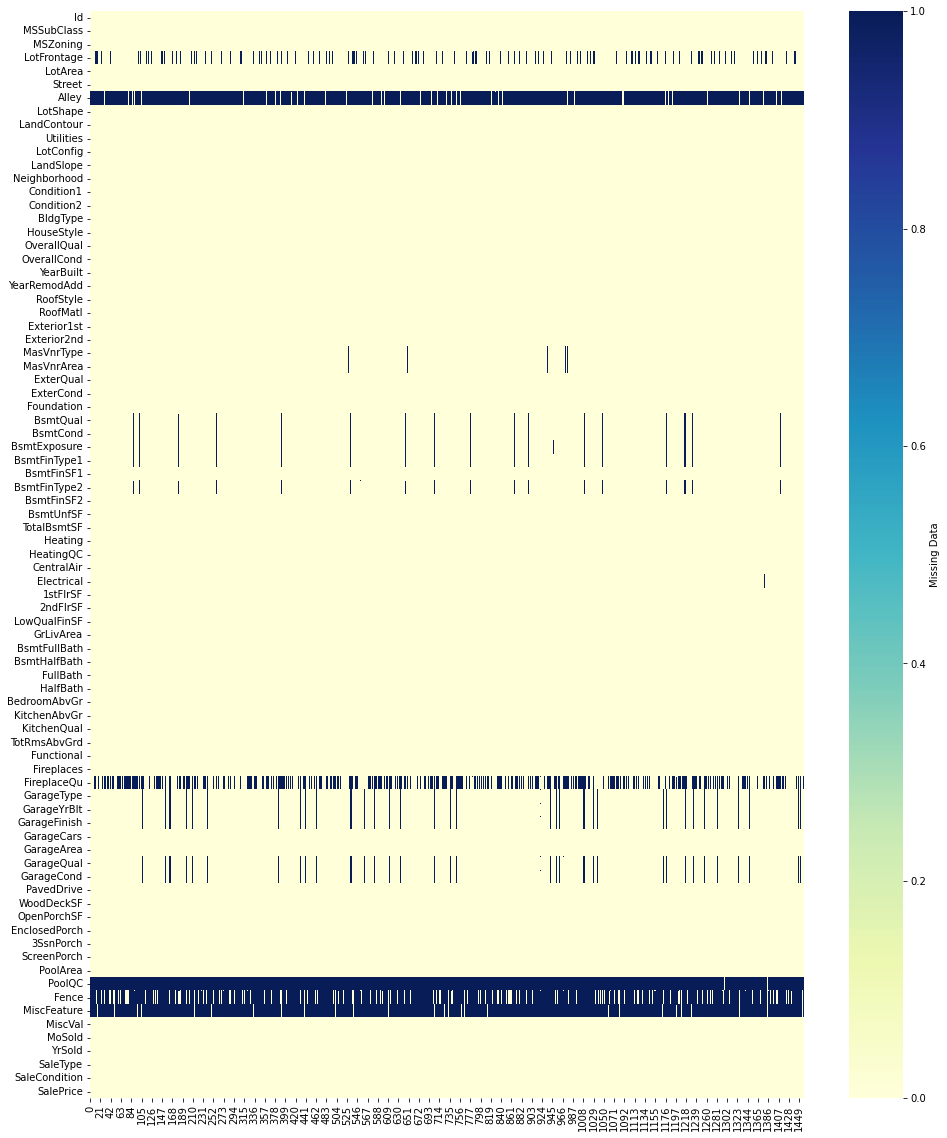

In [7]:
# missing values of each column (of each variable)-- visualization
plt.figure(figsize=(16,20))
sns.heatmap(origTrainDF.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [8]:
# missing values for each variable -- listed
pd.set_option('display.max_rows', None)  # display all the results
origTrainDF.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

The visualization and direct listing of missing values in each variable show that the following variables have significant numbers of missing values: LotFrontage, Alley, FireplaceQu, PoolQC, Fence and MiscFeature. Even with its missing values, LotFrontage still has approximately 80% actual values, so it will be retained in the dataset.  However, the other extreme missing value variables will be removed from the dataset.

In [9]:
# eliminate the variables with significant numbers of missing values
origTrainDF = origTrainDF.drop(columns = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'])

origTrainDF.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1          60       RL         65.0     8450   Pave      Reg         Lvl   
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0     2Story            7            5       2003          2003     Gable   
1     1Story            6            8       1976          1976     Gable   
2     2Story            7            5       2001          2002     Gable   
3     2Story            7            5       1915          1970     Gable   
4     2Story            8            5       2000          2000     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA   
1  CompShg     MetalSd     MetalSd       None         0.0        TA        TA   
2  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA   
3  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA   
4  CompShg     VinylSd     VinylSd    BrkFace       350.0        Gd        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0      PConc       Gd       TA           No          GLQ         706   
1     CBlock       Gd       TA           Gd          ALQ         978   
2      PConc       Gd       TA           Mn          GLQ         486   
3     BrkTil       TA       Gd           No          ALQ         216   
4      PConc       Gd       TA           Av          GLQ         655   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
0          Unf           0        150          856    GasA        Ex   
1          Unf           0        284         1262    GasA        Ex   
2          Unf           0        434          920    GasA        Ex   
3          Unf           0        540          756    GasA        Gd   
4          Unf           0        490         1145    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr       856       854             0       1710   
1          Y      SBrkr      1262         0             0       1262   
2          Y      SBrkr       920       866             0       1786   
3          Y      SBrkr       961       756             0       1717   
4          Y      SBrkr      1145      1053             0       2198   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0             1             0         2         1             3             1   
1             0             1         2         0             3             1   
2             1             0         2         1             3             1   
3             1             0         1         0             3             1   
4             1             0         2         1             4             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces GarageType  GarageYrBlt  \
0          Gd             8        Typ           0     Attchd       2003.0   
1          TA             6        Typ           1     Attchd       1976.0   
2          Gd             6        Typ           1     Attchd       2001.0   

In [10]:
# basic descriptive statistics of all the numerical variables
origTrainDF.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

### Modify and Create New Features

*Response variable 'SalePrice'*

As shown immediately above, 'SalePrice' possesses 1460 values (the number of rows in the dataset), so there does not appear to be missing values in 'SalePrice' (although this does not ensure all values are valid or possibly outiliers).

The basic statistics and distribution of 'SalePrice' are shown below.

In [11]:
# descriptive statistics of the dependent variable 'SalePrice'
origTrainDF.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In last week's assignment, the distribution of 'SalePrice' exhibiteed skewness towards the higher end values (as seen in boxplot and histogram).  This skewess can be addressed using a log(SalePrice) transformation.

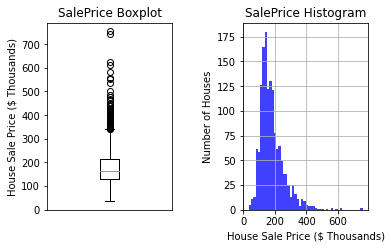

In [12]:
# initial visualizations of 'SalePrice' data (box plot and histogram)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)

# boxplot
ax1.boxplot(origTrainDF.SalePrice/1000)
ax1.set_ylabel('House Sale Price ($ Thousands)')
ax1.set_xticks([])
ax1.set_title('SalePrice Boxplot')

# histogram
ax2.hist(origTrainDF.SalePrice/1000, bins=50, facecolor='blue', alpha=0.75)
ax2.set_ylabel('Number of Houses')
ax2.set_xlabel('House Sale Price ($ Thousands)')
ax2.set_title('SalePrice Histogram')
ax2.grid(True)

plt.show()

In [13]:
# create new response variable 'logSalePrice'
origTrainDF['logSalePrice'] = np.log(origTrainDF['SalePrice'])

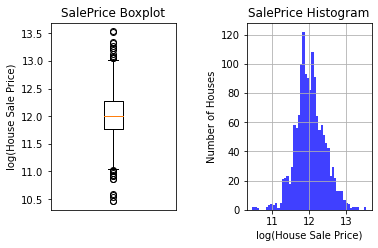

In [14]:
# visualizations of log-transformed 'SalePrice' data (box plot and histogram)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)

# boxplot
ax1.boxplot(origTrainDF.logSalePrice)
ax1.set_ylabel('log(House Sale Price)')
ax1.set_xticks([])
ax1.set_title('SalePrice Boxplot')

# histogram
ax2.hist(origTrainDF.logSalePrice, bins=50, facecolor='blue', alpha=0.75)
ax2.set_ylabel('Number of Houses')
ax2.set_xlabel('log(House Sale Price)')
ax2.set_title('SalePrice Histogram')
ax2.grid(True)

plt.show()

*Square Footage Variables*

Fellow students have suggested that combining square footage variables can create a better combined, square footage, predictor variable.

In [15]:
origTrainDF['TotalSF'] = origTrainDF['1stFlrSF'] + origTrainDF['2ndFlrSF'] + origTrainDF['BsmtFinSF1'] + origTrainDF['BsmtFinSF2']
origTrainDF['TotLivSF'] = origTrainDF['GrLivArea'] + origTrainDF['BsmtFinSF1'] + origTrainDF['BsmtFinSF2']
origTrainDF['TotArea'] = origTrainDF['GrLivArea'] + origTrainDF['TotalBsmtSF']

*Combine Year and Month dates into one variable*

In [16]:
# combine month sold with year sold (i.e., decimal number)
origTrainDF['YearMoSold'] = origTrainDF.YrSold + origTrainDF.MoSold/12
origTrainDF = origTrainDF.drop(columns = ['YrSold','MoSold'])

In [17]:
# check latest variables in dataframe
origTrainDF.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1          60       RL         65.0     8450   Pave      Reg         Lvl   
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0     2Story            7            5       2003          2003     Gable   
1     1Story            6            8       1976          1976     Gable   
2     2Story            7            5       2001          2002     Gable   
3     2Story            7            5       1915          1970     Gable   
4     2Story            8            5       2000          2000     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA   
1  CompShg     MetalSd     MetalSd       None         0.0        TA        TA   
2  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA   
3  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA   
4  CompShg     VinylSd     VinylSd    BrkFace       350.0        Gd        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0      PConc       Gd       TA           No          GLQ         706   
1     CBlock       Gd       TA           Gd          ALQ         978   
2      PConc       Gd       TA           Mn          GLQ         486   
3     BrkTil       TA       Gd           No          ALQ         216   
4      PConc       Gd       TA           Av          GLQ         655   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
0          Unf           0        150          856    GasA        Ex   
1          Unf           0        284         1262    GasA        Ex   
2          Unf           0        434          920    GasA        Ex   
3          Unf           0        540          756    GasA        Gd   
4          Unf           0        490         1145    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr       856       854             0       1710   
1          Y      SBrkr      1262         0             0       1262   
2          Y      SBrkr       920       866             0       1786   
3          Y      SBrkr       961       756             0       1717   
4          Y      SBrkr      1145      1053             0       2198   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0             1             0         2         1             3             1   
1             0             1         2         0             3             1   
2             1             0         2         1             3             1   
3             1             0         1         0             3             1   
4             1             0         2         1             4             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces GarageType  GarageYrBlt  \
0          Gd             8        Typ           0     Attchd       2003.0   
1          TA             6        Typ           1     Attchd       1976.0   
2          Gd             6        Typ           1     Attchd       2001.0   

-----------------------------------

*Split the original Kaggle.com training dataset into train and validation subsets*

In [18]:
# split initial training data 80(train):20(validation) using threshold T
T = 0.8 # specified threshold value
desiredRatio = T/(1-T)

trainDF, valDF = train_test_split(origTrainDF, train_size=T)

# count the number of samples in the split training and validation sets
nRowsTrain = trainDF.shape[0]
nColsTrain = trainDF.shape[1]
nRowsVal = valDF.shape[0]
nColsVal = valDF.shape[1]
actualRatio = nRowsTrain/nRowsVal

print('The new training subset has', nRowsTrain, 'rows and', nColsTrain, 'columns.')
print('The validation set has', nRowsVal, 'rows and', nColsVal, 'columns.')
print('\nThe desired size ratio of training:validation datasets is', desiredRatio)
print('The actual size ratio of training:validation datasets is', actualRatio)

The new training subset has 1168 rows and 79 columns.
The validation set has 292 rows and 79 columns.

The desired size ratio of training:validation datasets is 4.000000000000001
The actual size ratio of training:validation datasets is 4.0


In [19]:
trainDF = trainDF.sort_values(by=['Id'], ascending=True)
trainDF.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   
5   6          50       RL         85.0    14115   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   
5    AllPub    Inside       Gtl      Mitchel       Norm       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
1     1Story            6            8       1976          1976     Gable   
2     2Story            7            5       2001          2002     Gable   
3     2Story            7            5       1915          1970     Gable   
4     2Story            8            5       2000          2000     Gable   
5     1.5Fin            5            5       1993          1995     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
1  CompShg     MetalSd     MetalSd       None         0.0        TA        TA   
2  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA   
3  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA   
4  CompShg     VinylSd     VinylSd    BrkFace       350.0        Gd        TA   
5  CompShg     VinylSd     VinylSd       None         0.0        TA        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
1     CBlock       Gd       TA           Gd          ALQ         978   
2      PConc       Gd       TA           Mn          GLQ         486   
3     BrkTil       TA       Gd           No          ALQ         216   
4      PConc       Gd       TA           Av          GLQ         655   
5       Wood       Gd       TA           No          GLQ         732   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
1          Unf           0        284         1262    GasA        Ex   
2          Unf           0        434          920    GasA        Ex   
3          Unf           0        540          756    GasA        Gd   
4          Unf           0        490         1145    GasA        Ex   
5          Unf           0         64          796    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
1          Y      SBrkr      1262         0             0       1262   
2          Y      SBrkr       920       866             0       1786   
3          Y      SBrkr       961       756             0       1717   
4          Y      SBrkr      1145      1053             0       2198   
5          Y      SBrkr       796       566             0       1362   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1             0             1         2         0             3             1   
2             1             0         2         1             3             1   
3             1             0         1         0             3             1   
4             1             0         2         1             4             1   
5             1             0         1         1             1             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces GarageType  GarageYrBlt  \
1          TA             6        Typ           1     Attchd       1976.0   
2          Gd             6        Typ           1     Attchd       2001.0   
3          Gd             7        Typ           1     Detchd       1998.0   

In [20]:
valDF = valDF.sort_values(by=['Id'], ascending=True)
valDF.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0    1          60       RL         65.0     8450   Pave      Reg         Lvl   
6    7          20       RL         75.0    10084   Pave      Reg         Lvl   
13  14          20       RL         91.0    10652   Pave      IR1         Lvl   
16  17          20       RL          NaN    11241   Pave      IR1         Lvl   
20  21          60       RL        101.0    14215   Pave      IR1         Lvl   

   Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0     AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
6     AllPub    Inside       Gtl      Somerst       Norm       Norm     1Fam   
13    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
16    AllPub   CulDSac       Gtl        NAmes       Norm       Norm     1Fam   
20    AllPub    Corner       Gtl      NridgHt       Norm       Norm     1Fam   

   HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0      2Story            7            5       2003          2003     Gable   
6      1Story            8            5       2004          2005     Gable   
13     1Story            7            5       2006          2007     Gable   
16     1Story            6            7       1970          1970     Gable   
20     2Story            8            5       2005          2006     Gable   

   RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0   CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd   
6   CompShg     VinylSd     VinylSd      Stone       186.0        Gd   
13  CompShg     VinylSd     VinylSd      Stone       306.0        Gd   
16  CompShg     Wd Sdng     Wd Sdng    BrkFace       180.0        TA   
20  CompShg     VinylSd     VinylSd    BrkFace       380.0        Gd   

   ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0         TA      PConc       Gd       TA           No          GLQ   
6         TA      PConc       Ex       TA           Av          GLQ   
13        TA      PConc       Gd       TA           Av          Unf   
16        TA     CBlock       TA       TA           No          ALQ   
20        TA      PConc       Ex       TA           Av          Unf   

    BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0          706          Unf           0        150          856    GasA   
6         1369          Unf           0        317         1686    GasA   
13           0          Unf           0       1494         1494    GasA   
16         578          Unf           0        426         1004    GasA   
20           0          Unf           0       1158         1158    GasA   

   HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0         Ex          Y      SBrkr       856       854             0   
6         Ex          Y      SBrkr      1694         0             0   
13        Ex          Y      SBrkr      1494         0             0   
16        Ex          Y      SBrkr      1004         0             0   
20        Ex          Y      SBrkr      1158      1218             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        1710             1             0         2         1             3   
6        1694             1             0         2         0             3   
13       1494             0             0         2         0             3   
16       1004             1             0         1         0             2   
20       2376             0             0         3         1             4   

    KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces GarageType  \
0              1          Gd             8        Typ           0     Attchd   
6              1          Gd             7        Typ           1     Attchd   
13             1          Gd             7        Typ           1     Attchd   
16             1          TA

### CONTINUOUS VARIABLES

In [21]:
# create dataframe with the continuous variables
#  note that LotFrontage has missing values
continuousDF = trainDF[['SalePrice','logSalePrice','TotalSF','TotLivSF','TotArea',
                        'LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
                        'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                        'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                        '3SsnPorch','ScreenPorch','PoolArea','MiscVal']].copy()

In [22]:
# impute missing values (e.g., 'LotFrontage') with median value
continuousDF = continuousDF.fillna(continuousDF.median())

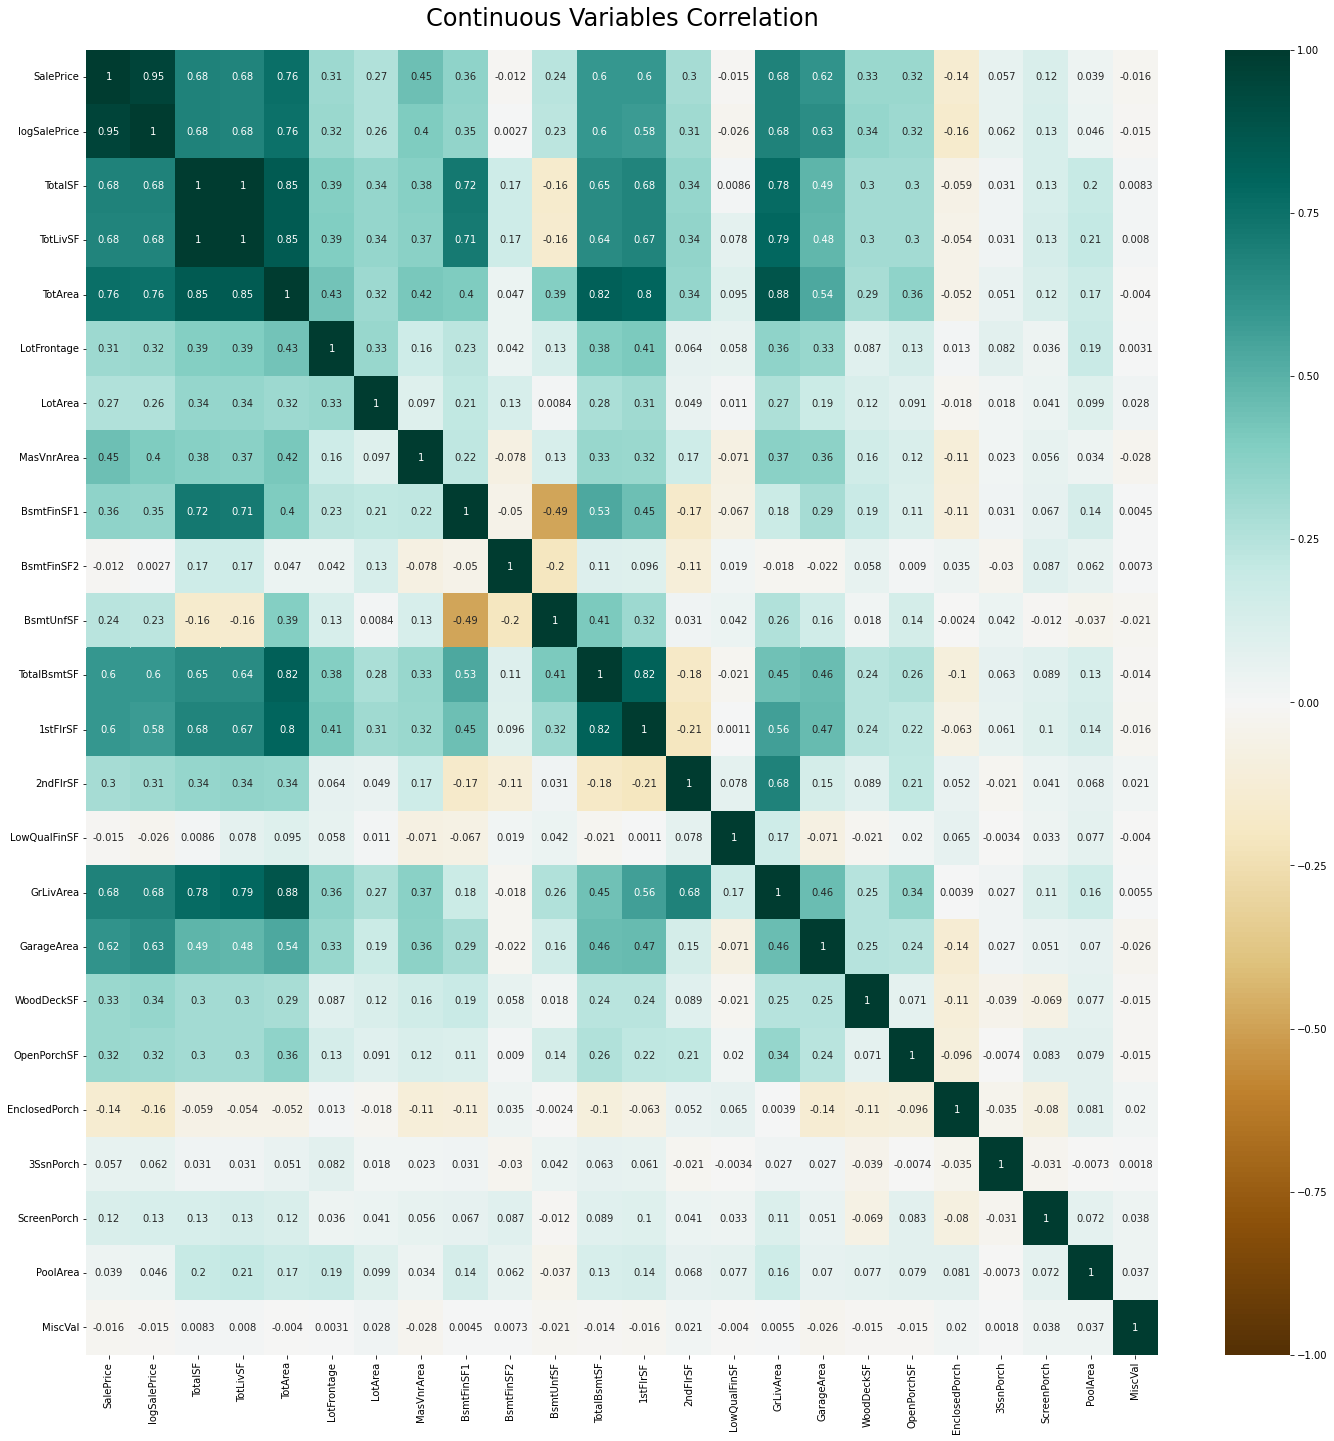

In [23]:
# create correlation heatmap
plt.figure(figsize=(24, 24))
continuousHeatmap = sns.heatmap(continuousDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
continuousHeatmap.set_title('Continuous Variables Correlation', fontdict={'fontsize':24}, pad=24);

COMMENT:  The newly-created 'TotArea' variable has the highest correlation with 'SalePrice' and 'logSalePrice' response variables as compared to the similar 'GrLivArea', 'TotalSF' and 'TotLivSF' variables. 'GarageArea' is also well-correlated with 'SalePrice' and 'logSalePrice', but it is also well-correlated with 'TotArea', so it will not be considered further.

**Polynomial and Piece-Wise representations of the 'TotArea' variable**
(these were discussed in the Week 2 assignment but are retained in this week's notebook)

A basic scatterplot of 'logSalePrice' vs. 'TotArea' is shown below.

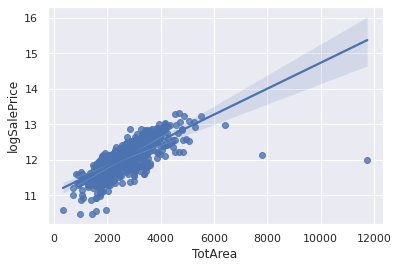

In [24]:
# create scatterplot of logSalePrice vs. TotArea
sns.set(font_scale = 1)
ax = sns.regplot(x='TotArea', y='logSalePrice', data=continuousDF)

COMMENT:  The scatterplot clearly shows samples that are probably outliers and should be removed.

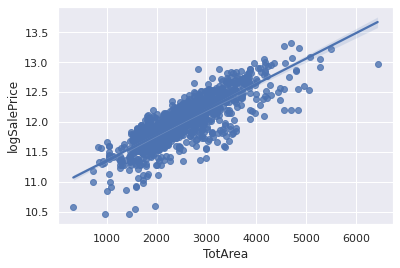

In [25]:
continuousDF_a = continuousDF[continuousDF['TotArea'] <= 7500]
trainDF_a = trainDF[trainDF['TotArea'] <= 7500]

# do this on the validation dataset as well
valDF = valDF[valDF['TotArea'] <= 7500]

# create new scatterplot of logSalePrice vs. TotArea
sns.set(font_scale = 1)
ax = sns.regplot(x='TotArea', y='logSalePrice', data=continuousDF_a)

In [26]:
# function to standardize dataframe columns
#  (zero mean, unit std deviation, assumed normal distribution)
def standardize(df):

  dtypes = list(zip(df.dtypes.index, map(str, df.dtypes)))

  # normalize numeric columns.
  for column, dtype in dtypes:
          df[column] -= df[column].mean()
          df[column] /= df[column].std()
  return df

In [27]:
# use sci-kit LinearRegression to generate basic model in the scatterplot
y = continuousDF_a.logSalePrice
X = continuousDF_a[['TotArea']].copy()
Xstd = standardize(X)
model = LinearRegression()
model.fit(Xstd, y)
b1 = model.coef_
b0 = model.intercept_
print('Intercept coeff (b0) =', b0)
print('Slope coeff (b1) =', b1)
R2 = model.score(X,y)
print('Coeff of determination (R2) =', R2)

Intercept coeff (b0) = 12.012120835396967
Slope coeff (b1) = [0.32326884]
Coeff of determination (R2) = 0.6662564286775827


Try again, but include a quadratic term to the model

In [28]:
# create dataframe with linear and quadratic terms
XX = continuousDF_a[['TotArea']].copy()
XX['TotArea2'] = continuousDF_a.TotArea * continuousDF_a.TotArea
XX.head()

TotArea  TotArea2
1     2524   6370576
2     2706   7322436
3     2473   6115729
4     3343  11175649
5     2158   4656964

In [29]:
XXstd = standardize(XX)
XXstd.head()

TotArea  TotArea2
1 -0.013026 -0.144194
2  0.226646  0.074995
3 -0.080187 -0.202879
4  1.065498  0.962293
5 -0.495004 -0.538796

In [30]:
# use sci-kit LinearRegression
model = LinearRegression()
model.fit(XXstd, y)
b0 = model.intercept_
coeffs = model.coef_
print('Intercept coeff (b0) =', b0)
print('Linear (b1) and Quadratic (b2) term coeffs are', coeffs)
R2 = model.score(XX,y)
print('Coeff of determination (R2) =', R2)

Intercept coeff (b0) = 12.012120835396967
Linear (b1) and Quadratic (b2) term coeffs are [ 0.5087682  -0.18981443]
Coeff of determination (R2) = 0.6765815731309304


COMMENT:  Note that R2 is improved slightly when the quadratic term is included as compared to when it is not included.

**Now explore a piece-wise representation:**

Maximum iteration reached.

Fitted x-values =  [ 334.        2656.2811316 6428.       ]
Corresponding fitted y-values = [10.93203501 12.11312262 13.43747665]
x-axis breakpoint(s) =  [2656.2811316]


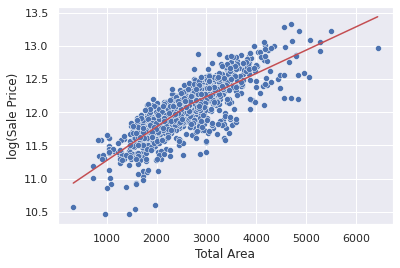

In [31]:
# based upon the original scatterplot, make initial guess for breakpoint(s)
# (on the TotArea axis)
initialBreakpoints = [2500]  # assumes only 1 breakpoint at TotArea = 2500

# function to determine where optimal breakpoints occur

# code was originally generated and described in
# Muggeo, V. M. (2003),
#   "Estimating regression models with unknown breakpoints,"
#    Statistics in medicine, 22(19), 3055-3071.
from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'Maximum iteration reached.\n' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution, breakpoints

# the data ...
X = np.array(continuousDF_a['TotArea'])
Y = np.array(continuousDF_a['logSalePrice'])

# create fitted line segments that change at the breakpoint(s)
fittedX, fittedY, fittedBreakpoints = SegmentedLinearReg( X, Y, initialBreakpoints )

# print out the values of fittedX
print("Fitted x-values = ", fittedX)

# print out the values of fittedY
print("Corresponding fitted y-values =", fittedY)

# print out the values of the breakpoint(s)
print("x-axis breakpoint(s) = ", fittedBreakpoints)

# plot the data and fitted line segments
sns.set(font_scale = 1)
chart = sns.scatterplot(
    data=continuousDF_a,
    x='TotArea', y='logSalePrice',
)
chart.set(ylabel='log(Sale Price)')
chart.set(xlabel='Total Area')
plt.plot( fittedX, fittedY, '-r' );

COMMENT:  The piecewise scatterplot adjusts to fit the data, but it also requires two different linearizations of the data, which might make it less convenient as compared to just adding a quadratic term to adjust the fit.

### DISCRETE/INTERVALLIC VARIABLES

In [32]:
# create dataframe with intervallic variables + response variable
#   note that GarageYrBlt(61) has missing values
intervalDF = trainDF_a[['logSalePrice','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath',
                         'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                         'TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','YearMoSold']]

# impute missing values ('GarageYrBlt') with median value
intervalDF = intervalDF.fillna(intervalDF.median())
intervalDF.head()

logSalePrice  YearBuilt  YearRemodAdd  BsmtFullBath  BsmtHalfBath  \
1     12.109011       1976          1976             0             1   
2     12.317167       2001          2002             1             0   
3     11.849398       1915          1970             1             0   
4     12.429216       2000          2000             1             0   
5     11.870600       1993          1995             1             0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
1         2         0             3             1             6           1   
2         2         1             3             1             6           1   
3         1         0             3             1             7           1   
4         2         1             4             1             9           1   
5         1         1             1             1             5           0   

   GarageYrBlt  GarageCars   YearMoSold  
1       1976.0           2  2007.416667  
2       2001.0           2  2008.750000  
3       1998.0           3  2006.166667  
4       2000.0           3  2009.000000  
5       1993.0           2  2009.833333

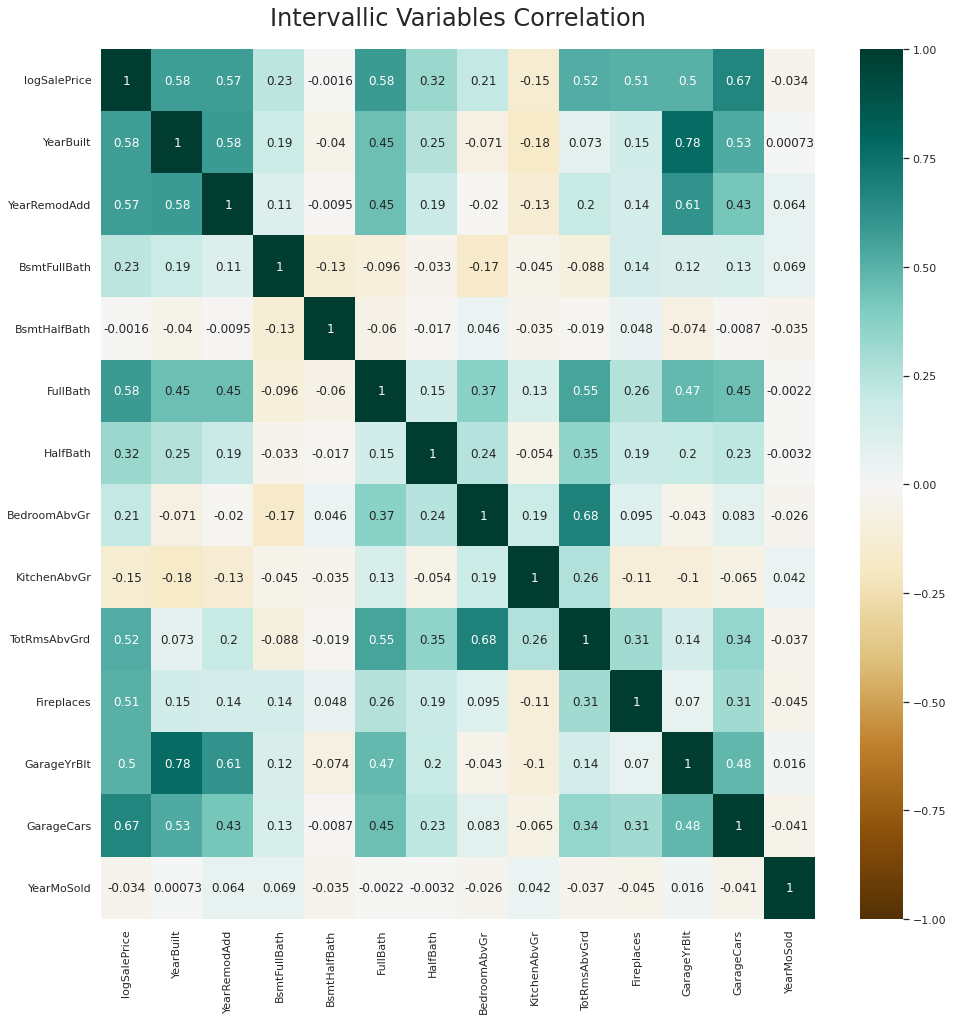

In [33]:
# create correlation heatmap
plt.figure(figsize=(16, 16))
intervallicHeatmap = sns.heatmap(intervalDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
intervallicHeatmap.set_title('Intervallic Variables Correlation', fontdict={'fontsize':24}, pad=24);

COMMENT:  In this correlation map, the highest correlation with 'logSalePrice' is with 'GarageCars' (i.e., garage size in terms of the number of cars it can hold).  Note that this was observed earlier with the continuous variables, where 'GarageArea' was a variable, and in that case, 'GarageArea' was not selected since it had signification correlation with 'TotArea'.

Other variables possessing high correlation with 'logSalePrice' are 'YearBuilt' and 'YearRemodeled' (i.e., newer homes or newly-remodeled homes exhibited higher sales prices).  However, these two variables have high correlation, so only one ('YearBuilt') will be selected for further evaluation.

### ORDINAL VARIABLES

These variables possess an inherent ordering of "goodness", but are not strictly intervallic.  However, to simplify things in this analysis, these variables were assumed to possess sufficient "intervallic-ness" such that they can be treated as if they were intervallic.

Note that the levels in most of these variables are designated by text descriptors and not numbers.  For those variables, the text descriptors were converted to integers such that they could be treated as numeric variables and correlation values could be obtained.

In [34]:
# create dataframe with ordinal variables (15 variables)

# note that BsmtQual(32), BsmtCond(32), BsmtExposure(33), BsmtFinType1(32), BsmtFinType2(33),
#  GarageFinish(61), GarageQual(61) and GarageCond(61) have NAs
#  (where the NANs are not necessarily missing values but might represent not applicable values)

# changing categorical to numeric ordinal values:
# (for cateories with NAs, have to change to numeric first and then impute NA with median value)
#   OverallQual, OverallCond are ranked 1(low)-10(high) already
#   ExterQual, ExterCond are ranked {Ex, Gd, TA, Fa, Po} ==> change to {5,4,3,2,1}
#   BsmtQual, BsmtCond are ranked {Ex,Gd,TA,Fa,Po,NA} ==> change to {5,4,3,2,1,median}
#   BsmtExposure is ranked {Gd,Av,Mn,No,NA} ==> change to {4,3,2,1,median}
#   BsmtFinType1/2 are ranked {GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA}
#     ==> change to {4,3,2,3,1,1,median}
#   HeatingQC is ranked {Ex,Gd,TA,Fa,Po} ==> change to {5,4,3,2,1}
#   KitchenQual is ranked {Ex, Gd, TA, Fa, Po} ==> change to {5,4,3,2,1}
#   Functional ranked {Typ,Min1,Min2,Mod,Maj1,Maj2,Sev,Sal} ==> change to {5,4,4,3,2,2,1,0}
#   FireplaceQu (ELIMINATED ALREADY)
#   GarageFinish is ranked {Fin, RFn, Unf, NA} ==> change to {3,2,1,median}
#   GarageQual is ranked {Ex,Gd,TA,Fa,Po,NA} ==> change to {5,4,3,2,1,median}
#   GarageCond is ranked {Ex,Gd,TA,Fa,Po,NA} ==> change to {5,4,3,2,1,median}
#   PoolQC (ELIMINATED ALREADY)

ordinalDF = trainDF_a[['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual',
                         'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                         'HeatingQC','KitchenQual','Functional',
                         'GarageFinish','GarageQual','GarageCond']]
ordinalDF.head()

OverallQual  OverallCond ExterQual ExterCond BsmtQual BsmtCond  \
1            6            8        TA        TA       Gd       TA   
2            7            5        Gd        TA       Gd       TA   
3            7            5        TA        TA       TA       Gd   
4            8            5        Gd        TA       Gd       TA   
5            5            5        TA        TA       Gd       TA   

  BsmtExposure BsmtFinType1 BsmtFinType2 HeatingQC KitchenQual Functional  \
1           Gd          ALQ          Unf        Ex          TA        Typ   
2           Mn          GLQ          Unf        Ex          Gd        Typ   
3           No          ALQ          Unf        Gd          Gd        Typ   
4           Av          GLQ          Unf        Ex          Gd        Typ   
5           No          GLQ          Unf        Ex          TA        Typ   

  GarageFinish GarageQual GarageCond  
1          RFn         TA         TA  
2          RFn         TA         TA  
3          Unf         TA         TA  
4          RFn         TA         TA  
5          Unf         TA         TA

In [35]:
# function to define numerical values (0-5) of "goodness" for different categories
def qualityNames_to_number(qualVal):
    if qualVal == 'Ex':
        return 5
    elif qualVal == 'Typ':
        return 5
    elif qualVal == 'Gd':
        return 4
    elif qualVal == 'Min1':
        return 4
    elif qualVal == 'Min2':
        return 4
    elif qualVal == 'GLQ':
        return 4
    elif qualVal == 'TA':
        return 3
    elif qualVal == 'Av':
        return 3
    elif qualVal == 'Fin':
        return 3
    elif qualVal == 'Mod':
        return 3
    elif qualVal == 'ALQ':
        return 3
    elif qualVal == 'Rec':
        return 3
    elif qualVal == 'Fa':
        return 2
    elif qualVal == 'Mn':
        return 2
    elif qualVal == 'Maj1':
        return 2
    elif qualVal == 'Maj2':
        return 2
    elif qualVal == 'RFn':
        return 2
    elif qualVal == 'BLQ':
        return 2
    elif qualVal == 'Po':
        return 1
    elif qualVal == 'No':
        return 1
    elif qualVal == 'Unf':
        return 1
    elif qualVal == 'Sev':
        return 1
    elif qualVal == 'LwQ':
        return 1
    elif qualVal == 'Sev':
        return 1
    elif qualVal == 'Sal':
        return 0
    elif np.isnan(qualVal):
        pass # don't do anything
    else: 
        return 'ERROR'

oldColNames = ('ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual',
               'Functional','GarageFinish','GarageQual','GarageCond')

newColNames = ('ExterQualNum','ExterCondNum','BsmtQualNum','BsmtCondNum',
               'BsmtExposureNum','BsmtFinType1Num','BsmtFinType2Num',
                'HeatingQCNum','KitchenQualNum','FunctionalNum',
                'GarageFinishNum','GarageQualNum','GarageCondNum')


for aa in range(len(oldColNames)):
    oldName = oldColNames[aa]
    newName = newColNames[aa]
    ordinalDF[newName] = ordinalDF.loc[:,oldName].apply(qualityNames_to_number)
    #ordinalDF[newName] = ordinalDF[oldName].apply(qualityNames_to_number)
    
# drop the old (non-numeric) categories
ordinalNumDF = ordinalDF.select_dtypes(exclude=['object'])

# impute missing values with median value
ordinalNumDF = ordinalNumDF.fillna(ordinalNumDF.median())

# add the 'logSalePrice' column
ordinalNumDF['logSalePrice'] = trainDF_a[['logSalePrice']]
ordinalNumDF.head(25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OverallQual  OverallCond  ExterQualNum  ExterCondNum  BsmtQualNum  \
1             6            8             3             3          4.0   
2             7            5             4             3          4.0   
3             7            5             3             3          3.0   
4             8            5             4             3          4.0   
5             5            5             3             3          4.0   
7             7            6             3             3          4.0   
8             7            5             3             3          3.0   
9             5            6             3             3          3.0   
10            5            5             3             3          3.0   
11            9            5             5             3          5.0   
12            5            6             3             3          3.0   
14            6            5             3             3          3.0   
15            7            8             3             3          3.0   
17            4            5             3             3          4.0   
18            5            5             3             3          3.0   
19            5            6             3             3          3.0   
21            7            7             3             3          3.0   
22            8            5             4             3          4.0   
23            5            7             3             3          4.0   
24            5            8             3             4          3.0   
25            8            5             4             3          4.0   
26            5            7             3             3          3.0   
27            8            5             4             3          5.0   
28            5            6             3             3          3.0   
29            4            6             3             3          3.0   

    BsmtCondNum  BsmtExposureNum  BsmtFinType1Num  BsmtFinType2Num  \
1           3.0              4.0              3.0              1.0   
2           3.0              2.0              4.0              1.0   
3           4.0              1.0              3.0              1.0   
4           3.0              3.0              4.0              1.0   
5           3.0              1.0              4.0              1.0   
7           3.0              2.0              3.0              2.0   
8           3.0              1.0              1.0              1.0   
9           3.0              1.0              4.0              1.0   
10          3.0              1.0              3.0              1.0   
11          3.0              1.0              4.0              1.0   
12          3.0              1.0              3.0              1.0   
14          3.0              1.0              2.0              1.0   
15          3.0              1.0              1.0              1.0   
17          3.0              1.0              3.0              1.0   
18          3.0              1.0              4.0              1.0   
19          3.0              1.0              1.0              1.0   
21          3.0              1.0              1.0              1.0   
22          3.0              1.0              1.0              1.0   
23          3.0              1.0              4.0              1.0   
24          3.0              2.0              3.0              3.0   
25          3.0              1.0              1.0              1.0   
26          3.0              2.0              2.0              3.0   
27          3.0              1.0              4.0              1.0   
28          3.0              4.0              2.0              1.0   
29          3.0              1.0              1.0              1.0   

    HeatingQCNum  KitchenQualNum  FunctionalNum  GarageFinishNum  \
1              5               3              5              2.0   
2              5               4              5              2.0   
3              4               4              5              1.0   
4           

Text(0.5, 1.0, 'Ordinal Variables Correlation')

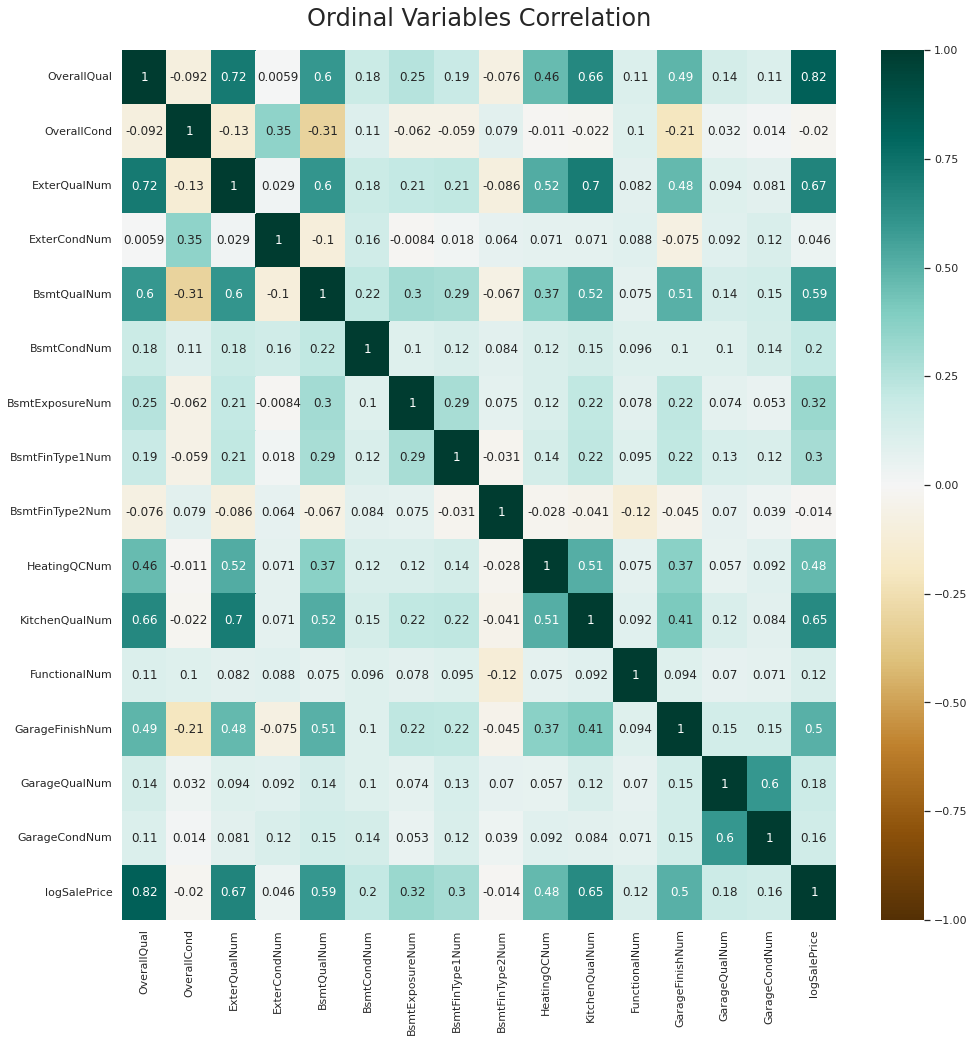

In [36]:
# create correlation heatmap
plt.figure(figsize=(16, 16))
ordinalHeatmap = sns.heatmap(ordinalNumDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
ordinalHeatmap.set_title('Ordinal Variables Correlation', fontdict={'fontsize':24}, pad=24)

COMMENT:  'OverallQual' exhibits the highest correlation with 'logSalePrice'.  It is also highly correlated with the next several ordinal variables that possess relatively high correlation with 'logSalePrice' (BsmtQual, ExterQual and KitchenQual).  In the Week 2 assignment, only 'OverallQual' was selected for further evaluation from these ordinal variables.  However, for this week's assignment (regularization), the 'KitchenQual' variable will be included to see how the various regularization methods (Lasso, Ridge, and ElasticNet) address this.

In [37]:
# add the 'KitchenQualNum' variable to the current training dataset
trainDF_a['KitchenQualNum'] = ordinalDF['KitchenQualNum']
trainDF_a.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   
5   6          50       RL         85.0    14115   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   
5    AllPub    Inside       Gtl      Mitchel       Norm       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
1     1Story            6            8       1976          1976     Gable   
2     2Story            7            5       2001          2002     Gable   
3     2Story            7            5       1915          1970     Gable   
4     2Story            8            5       2000          2000     Gable   
5     1.5Fin            5            5       1993          1995     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
1  CompShg     MetalSd     MetalSd       None         0.0        TA        TA   
2  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA   
3  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA   
4  CompShg     VinylSd     VinylSd    BrkFace       350.0        Gd        TA   
5  CompShg     VinylSd     VinylSd       None         0.0        TA        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
1     CBlock       Gd       TA           Gd          ALQ         978   
2      PConc       Gd       TA           Mn          GLQ         486   
3     BrkTil       TA       Gd           No          ALQ         216   
4      PConc       Gd       TA           Av          GLQ         655   
5       Wood       Gd       TA           No          GLQ         732   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
1          Unf           0        284         1262    GasA        Ex   
2          Unf           0        434          920    GasA        Ex   
3          Unf           0        540          756    GasA        Gd   
4          Unf           0        490         1145    GasA        Ex   
5          Unf           0         64          796    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
1          Y      SBrkr      1262         0             0       1262   
2          Y      SBrkr       920       866             0       1786   
3          Y      SBrkr       961       756             0       1717   
4          Y      SBrkr      1145      1053             0       2198   
5          Y      SBrkr       796       566             0       1362   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1             0             1         2         0             3             1   
2             1             0         2         1             3             1   
3             1             0         1         0             3             1   
4             1             0         2         1             4             1   
5             1             0         1         1             1             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces GarageType  GarageYrBlt  \
1          TA             6        Typ           1     Attchd       1976.0   
2          Gd             6        Typ           1     Attchd       2001.0   
3          Gd             7        Typ           1     Detchd       1998.0   

In [38]:
# add the 'KitchenQualNum' variable to the validation dataset
valDF['KitchenQualNum'] = valDF.loc[:,'KitchenQual'].apply(qualityNames_to_number)
valDF.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0    1          60       RL         65.0     8450   Pave      Reg         Lvl   
6    7          20       RL         75.0    10084   Pave      Reg         Lvl   
13  14          20       RL         91.0    10652   Pave      IR1         Lvl   
16  17          20       RL          NaN    11241   Pave      IR1         Lvl   
20  21          60       RL        101.0    14215   Pave      IR1         Lvl   

   Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0     AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
6     AllPub    Inside       Gtl      Somerst       Norm       Norm     1Fam   
13    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
16    AllPub   CulDSac       Gtl        NAmes       Norm       Norm     1Fam   
20    AllPub    Corner       Gtl      NridgHt       Norm       Norm     1Fam   

   HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0      2Story            7            5       2003          2003     Gable   
6      1Story            8            5       2004          2005     Gable   
13     1Story            7            5       2006          2007     Gable   
16     1Story            6            7       1970          1970     Gable   
20     2Story            8            5       2005          2006     Gable   

   RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0   CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd   
6   CompShg     VinylSd     VinylSd      Stone       186.0        Gd   
13  CompShg     VinylSd     VinylSd      Stone       306.0        Gd   
16  CompShg     Wd Sdng     Wd Sdng    BrkFace       180.0        TA   
20  CompShg     VinylSd     VinylSd    BrkFace       380.0        Gd   

   ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0         TA      PConc       Gd       TA           No          GLQ   
6         TA      PConc       Ex       TA           Av          GLQ   
13        TA      PConc       Gd       TA           Av          Unf   
16        TA     CBlock       TA       TA           No          ALQ   
20        TA      PConc       Ex       TA           Av          Unf   

    BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0          706          Unf           0        150          856    GasA   
6         1369          Unf           0        317         1686    GasA   
13           0          Unf           0       1494         1494    GasA   
16         578          Unf           0        426         1004    GasA   
20           0          Unf           0       1158         1158    GasA   

   HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0         Ex          Y      SBrkr       856       854             0   
6         Ex          Y      SBrkr      1694         0             0   
13        Ex          Y      SBrkr      1494         0             0   
16        Ex          Y      SBrkr      1004         0             0   
20        Ex          Y      SBrkr      1158      1218             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        1710             1             0         2         1             3   
6        1694             1             0         2         0             3   
13       1494             0             0         2         0             3   
16       1004             1             0         1         0             2   
20       2376             0             0         3         1             4   

    KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces GarageType  \
0              1          Gd             8        Typ           0     Attchd   
6              1          Gd             7        Typ           1     Attchd   
13             1          Gd             7        Typ           1     Attchd   
16             1          TA

### NON-ORDINAL, CATEGORICAL VARIABLES

These variables are not numeric, nor do they possess an inherent order of "goodness".  Swarmplots were created to visually evaluate the distributions of these variables with respect to 'logSalePrice'.

In [39]:
# create tuple of column names
catColNames = ('MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
'Exterior2nd','Foundation','Heating','Electrical','GarageType','PavedDrive','SaleType')

In [40]:
# create dataframe with non-ordinal categorical variables (23 variables)
#   note that Electrical and GarageType have missing values

categoricalDF = trainDF_a[['MSSubClass','MSZoning','Street','LotShape','LandContour',
                          'Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
                          'Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',
                          'Exterior1st','Exterior2nd','Foundation','Heating',
                          'Electrical','GarageType','PavedDrive','SaleType']].copy()

# impute the one Electrical missing value with most frequent (i.e., mode)
categoricalDF.Electrical = categoricalDF.Electrical.fillna(categoricalDF.Electrical.mode()[0])

# for the 61 missing GarageType, assume NaN means there is no garage ==> impute with 'None'
categoricalDF.GarageType = categoricalDF.GarageType.fillna('None')

# add the 'logSalePrice' column
categoricalDF['logSalePrice'] = trainDF_a['logSalePrice']
categoricalDF.head()

MSSubClass MSZoning Street LotShape LandContour Utilities LotConfig  \
1          20       RL   Pave      Reg         Lvl    AllPub       FR2   
2          60       RL   Pave      IR1         Lvl    AllPub    Inside   
3          70       RL   Pave      IR1         Lvl    AllPub    Corner   
4          60       RL   Pave      IR1         Lvl    AllPub       FR2   
5          50       RL   Pave      IR1         Lvl    AllPub    Inside   

  LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle  \
1       Gtl      Veenker      Feedr       Norm     1Fam     1Story     Gable   
2       Gtl      CollgCr       Norm       Norm     1Fam     2Story     Gable   
3       Gtl      Crawfor       Norm       Norm     1Fam     2Story     Gable   
4       Gtl      NoRidge       Norm       Norm     1Fam     2Story     Gable   
5       Gtl      Mitchel       Norm       Norm     1Fam     1.5Fin     Gable   

  RoofMatl Exterior1st Exterior2nd Foundation Heating Electrical GarageType  \
1  CompShg     MetalSd     MetalSd     CBlock    GasA      SBrkr     Attchd   
2  CompShg     VinylSd     VinylSd      PConc    GasA      SBrkr     Attchd   
3  CompShg     Wd Sdng     Wd Shng     BrkTil    GasA      SBrkr     Detchd   
4  CompShg     VinylSd     VinylSd      PConc    GasA      SBrkr     Attchd   
5  CompShg     VinylSd     VinylSd       Wood    GasA      SBrkr     Attchd   

  PavedDrive SaleType  logSalePrice  
1          Y       WD     12.109011  
2          Y       WD     12.317167  
3          Y       WD     11.849398  
4          Y       WD     12.429216  
5          Y       WD     11.870600

In [41]:
catColNames = categoricalDF.columns.values.tolist()
catColNames.remove('logSalePrice')
print(catColNames)
len(catColNames)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'SaleType']


23

In [42]:
# generate swarmplots for the different categories in each categorical variable
sns.set(font_scale = 2)  # set font scale
rowIndex = 0
colIndex = 0
for aa in range(len(catColNames)):
    chart = sns.catplot(
        data=categoricalDF,
        x=catColNames[aa], y='logSalePrice',
        kind='swarm',
        palette='Set1',
        height=9, aspect=3,
        s=4
    )
    chart.set_xticklabels(rotation=45)
    chart.set(ylabel='log(SalePrice)')
 
sns.set(font_scale = 1)  # reset font scale

Output hidden; open in https://colab.research.google.com to view.

COMMENT:  In evaluating the swarmplots, it is desired to have variables that 1) exhibit good distribution of the samples across the different categories (i.e., the vast majority of samples are not contained in only 1 or 2 categories), and 2) have notable variation in 'SalePrice' that is related to the category in which samples reside.

'Neighborhood' ("Location, Location, Location") and possibly 'MSSubClass' (the type of dwelling -- single family home, etc.) appear to represent these desired characteristics the best.  However, these variables have a relatively large number of categories, and these numbers should be reduced to make an eventual model more practical.

To reduce the number fo different categories, the descriptive statistics of individual categories will be used to create vectors and then vectors with similar statistics will be combined using k-means clustering.

***NOTE:  In the Week 2 Assignment, only 'Neighborhood' was processed using k-means clustering to reduce the number of different categories.  This week, both 'Neighborhood' and 'MSSubClass' were processed using k-means clustering to reduce the number of different categories. ***

**Using k-means clustering to reduce the number of different levels in 'Neighborhood'**

In [43]:
# create new dataframe with dependent and independent variable
neighborhoodDF = categoricalDF[['logSalePrice','Neighborhood']].copy()
neighborhoodDF.shape

(1166, 2)

In [44]:
# display DF
neighborhoodDF.head()

logSalePrice Neighborhood
1     12.109011      Veenker
2     12.317167      CollgCr
3     11.849398      Crawfor
4     12.429216      NoRidge
5     11.870600      Mitchel

In [45]:
# count how many unique categories in variable 'Neighborhood'
nNeighborhoods = neighborhoodDF['Neighborhood'].nunique()
nNeighborhoods

25

In [46]:
# create a Series of the neighborhood names
neighborhoodNames = neighborhoodDF['Neighborhood'].unique()

# names of the default descriptive stats (used to create indices of DF below)
rowNames = ["count","mean","std","min","25%","50%","75%","max"]

# initialize a dataframe to store the SalePrice ($K) statistics of each neighborhood region
neighStatsDF = pd.DataFrame(index=rowNames, columns=neighborhoodNames)

# populate the dataframe
for i in range(0, nNeighborhoods):
    
    # get the name of a neighborhood region
    regionName = neighborhoodNames[i]
    
    # get the rows in NeighborhoodDF that have this region
    rowsWithRegionOfInterestDF = neighborhoodDF.loc[neighborhoodDF['Neighborhood']==regionName]
    
    # extract the logSalePrice column from this new dataframe
    logSalePricesForThisRegion = rowsWithRegionOfInterestDF['logSalePrice']
    
    # get the descriptive statistics of the logSalePrice for this region
    #  and store statistics as dataframe column
    neighStatsDF.iloc[:,i] = logSalePricesForThisRegion.describe()

In [47]:
# remove the 1st row (counts) from statsDF
neighStatsDF_a = neighStatsDF.iloc[1: , :]

In [48]:
# transpose the dataframe so that categories are the rows
neighStatsDFTrans = neighStatsDF_a.transpose()

In [49]:
# inmpute any missing values (e.g., std deviations of categories with only
#  one variable) with a very low, near-zero value
neighStatsDFTrans = neighStatsDFTrans.fillna(0.000001)
neighStatsDFTrans

mean       std        min        25%        50%        75%  \
Veenker  12.319460  0.292041  11.998433  12.116474  12.233932  12.482396   
CollgCr  12.152910  0.248776  11.608236  11.950324  12.181779  12.313803   
Crawfor  12.204567  0.333215  11.411446  11.971133  12.207880  12.395468   
NoRidge  12.628469  0.181633  12.305918  12.487485  12.577636  12.736701   
Mitchel  11.949034  0.221989  11.344507  11.802309  11.949534  12.045020   
NWAmes   12.154121  0.180817  11.813030  12.043554  12.132157  12.242814   
OldTown  11.697445  0.352469  10.542706  11.546355  11.694830  11.838606   
BrkSide  11.661869  0.366351  10.578980  11.512925  11.699396  11.826607   
Sawyer   11.804942  0.192934  11.041048  11.743031  11.812660  11.922539   
NridgHt  12.642697  0.294912  11.944708  12.507707  12.666657  12.829870   
NAmes    11.860702  0.204045  11.379394  11.740029  11.849398  11.960806   
SawyerW  12.084865  0.281751  11.314475  11.887878  12.100712  12.289888   
IDOTRR   11.422347  0.418679  10.460242  11.231630  11.531591  11.699405   
MeadowV  11.485292  0.222897  11.225243  11.341531  11.401853  11.677501   
Timber   12.308024  0.261725  11.831379  12.106207  12.251902  12.505714   
Somerst  12.287078  0.237512  11.891362  12.100970  12.276527  12.430954   
Gilbert  12.158784  0.169461  11.856515  12.071109  12.106622  12.205698   
StoneBr  12.528311  0.344973  12.043554  12.248250  12.501907  12.820788   
ClearCr  12.240740  0.256881  11.775290  12.107562  12.207321  12.393067   
Edwards  11.722421  0.297924  10.976782  11.540510  11.736069  11.865216   
NPkVill  11.853041  0.068037  11.755872  11.804592  11.891362  11.903264   
Blmngtn  12.170434  0.165032  11.982273  12.066811  12.106252  12.271345   
BrDale   11.526537  0.135949  11.326596  11.407519  11.542060  11.632921   
SWISU    11.853519  0.276643  11.002100  11.767538  11.849398  12.010292   
Blueste  11.925035  0.000001  11.925035  11.925035  11.925035  11.925035   

               max  
Veenker  12.860999  
CollgCr  12.959539  
Crawfor  12.880292  
NoRidge  13.053013  
Mitchel  12.509874  
NWAmes   12.610871  
OldTown  13.071070  
BrkSide  12.317167  
Sawyer   12.154779  
NridgHt  13.323927  
NAmes    12.751300  
SawyerW  12.665394  
IDOTRR   12.040608  
MeadowV  11.927681  
Timber   12.834681  
Somerst  12.955127  
Gilbert  12.841326  
StoneBr  13.229568  
ClearCr  12.700769  
Edwards  12.676076  
NPkVill  11.908340  
Blmngtn  12.485827  
BrDale   11.736069  
SWISU    12.206073  
Blueste  11.925035

In [50]:
# min-max the columns so that all statistic vector elements are weighted equally
neighStatsDFTrans_scaled = MinMaxScaler().fit_transform(neighStatsDFTrans)

In [51]:
# use of k-means to combine neighborhoods with similar statistics

# determine optimal value for K
distortions = []
inertias = []

K = range(1, nNeighborhoods)
for k in K:
    
    # building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(neighStatsDFTrans_scaled)
    kmeanModel.fit(neighStatsDFTrans_scaled)
    
    distortions.append(sum(np.min(cdist(neighStatsDFTrans_scaled,
                kmeanModel.cluster_centers_,'euclidean'),axis=1)) / neighStatsDFTrans_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)

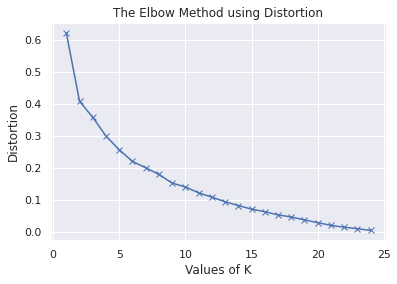

In [52]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

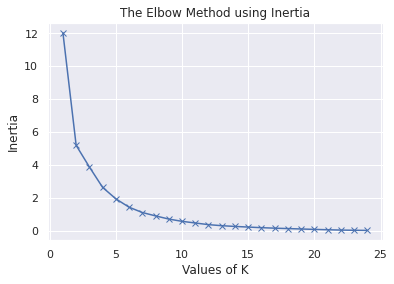

In [53]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

COMMENT:  The elbow curves suggest there is little improvement per additional "k" after about k=4 or k=5 clusters.

In [54]:
# create new dataframe with Neighborhood-related columns
nbrHdClusterDF = neighborhoodDF[['logSalePrice','Neighborhood']].copy()

-----------------------------------------------------

In [55]:
# specify value for k (k=4 clusters in this case)
nbrHd_k = 4

# determine which cluster each neighborhood belongs to
kmeans = KMeans(n_clusters = nbrHd_k,
        init = 'k-means++',
        random_state = 42)
y_kmeans_nbrHd4 = kmeans.fit_predict(neighStatsDFTrans_scaled)
neighStatsDFTrans['Cluster_4'] = y_kmeans_nbrHd4.tolist()

# create dictionary to map Neighborhood category levels to the corresponding cluster number
nbrHd_clusterNum_Dict_4 = dict(zip(neighStatsDFTrans.index, neighStatsDFTrans.Cluster_4))

# map the cluster numbers to the names of the different category levels
nbrHdClusterDF['nbrHdCluster_k4']=nbrHdClusterDF['Neighborhood'].map(nbrHd_clusterNum_Dict_4)

-----------------------------------------------

In [56]:
# specify value for k (k=5 clusters in this case)
nbrHd_k = 5

# determine which cluster each neighborhood belongs to
kmeans = KMeans(n_clusters = nbrHd_k,
        init = 'k-means++',
        random_state = 42)
y_kmeans_nbrHd5 = kmeans.fit_predict(neighStatsDFTrans_scaled)
neighStatsDFTrans['Cluster_5'] = y_kmeans_nbrHd5.tolist()

# create dictionary to map Neighborhood category levels to the corresponding cluster number
nbrHd_clusterNum_Dict_5 = dict(zip(neighStatsDFTrans.index, neighStatsDFTrans.Cluster_5))

# map the cluster numbers to the names of the different category levels
nbrHdClusterDF['nbrHdCluster_k5']=nbrHdClusterDF['Neighborhood'].map(nbrHd_clusterNum_Dict_5)

-------------------------------

In [57]:
# display the 'Neighborhood' cluster mapping dataframe showing k=4 and k=5 cluster mappings
nbrHdClusterDF.head(25)

logSalePrice Neighborhood  nbrHdCluster_k4  nbrHdCluster_k5
1      12.109011      Veenker                2                2
2      12.317167      CollgCr                2                2
3      11.849398      Crawfor                2                2
4      12.429216      NoRidge                1                0
5      11.870600      Mitchel                3                1
7      12.206073       NWAmes                2                2
8      11.774520      OldTown                0                1
9      11.678440      BrkSide                0                1
10     11.771436       Sawyer                3                1
11     12.751300      NridgHt                1                0
12     11.877569       Sawyer                3                1
14     11.964001        NAmes                3                1
15     11.790557      BrkSide                0                1
17     11.407565       Sawyer                3                1
18     11.976659      SawyerW                2                2
19     11.842229        NAmes                3                1
21     11.845103       IDOTRR                0                4
22     12.345835      CollgCr                2                2
23     11.774520      MeadowV                3                4
24     11.944708       Sawyer                3                1
25     12.454104      NridgHt                1                0
26     11.811547        NAmes                3                1
27     12.631340      NridgHt                1                0
28     12.242887        NAmes                3                1
29     11.134589      BrkSide                0                1

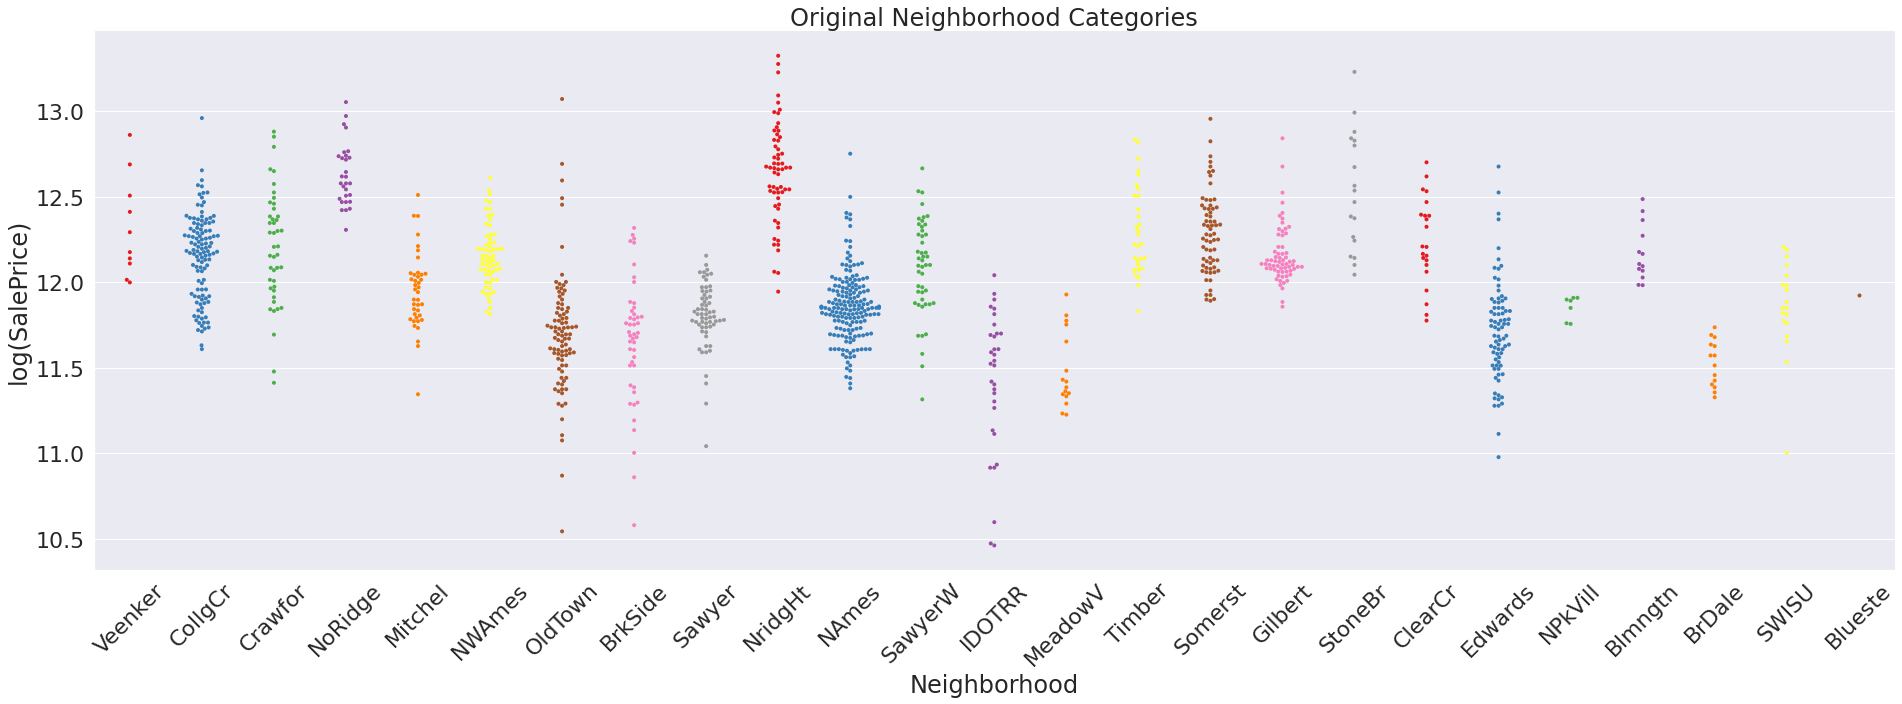

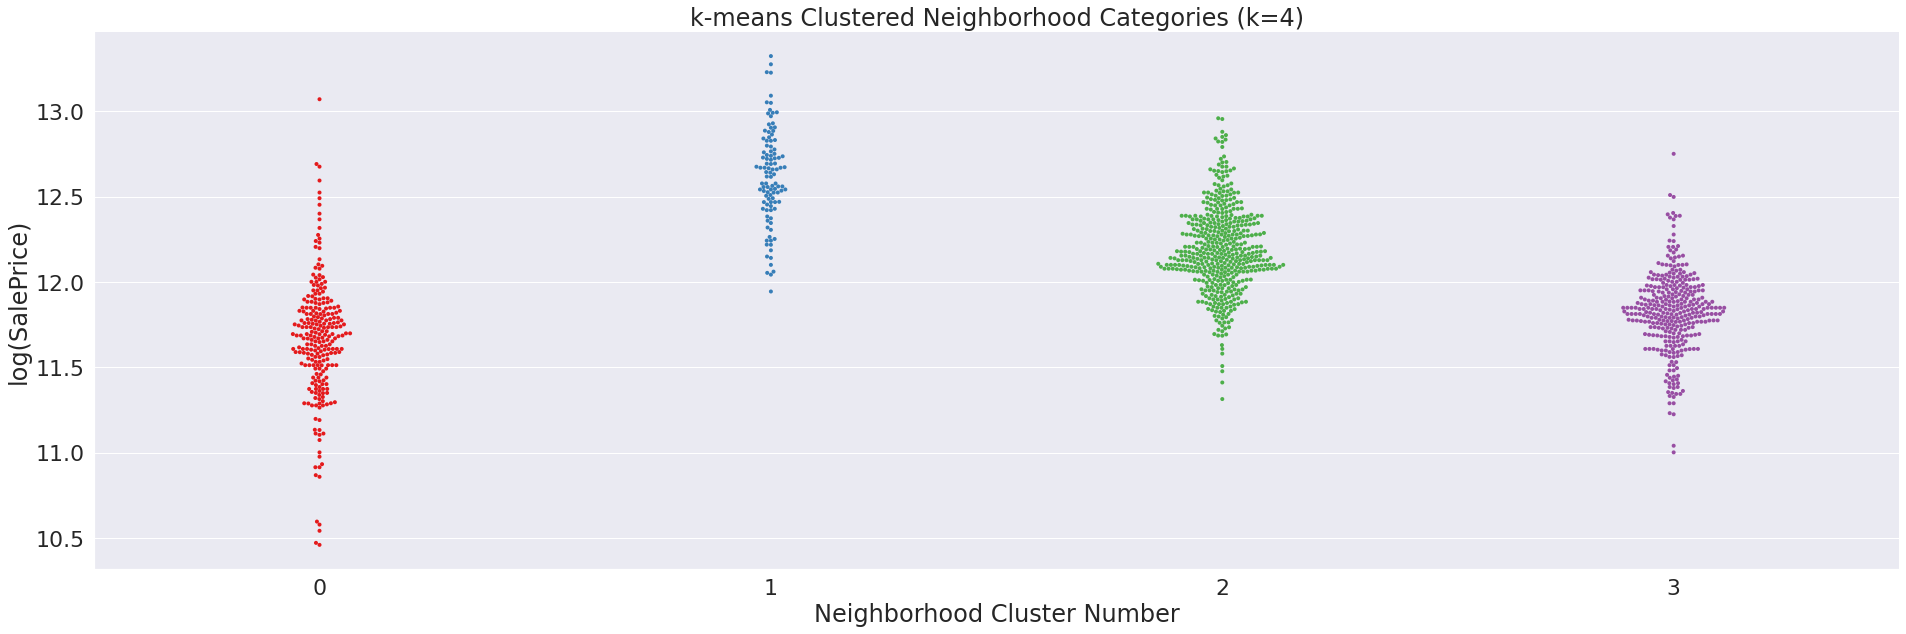

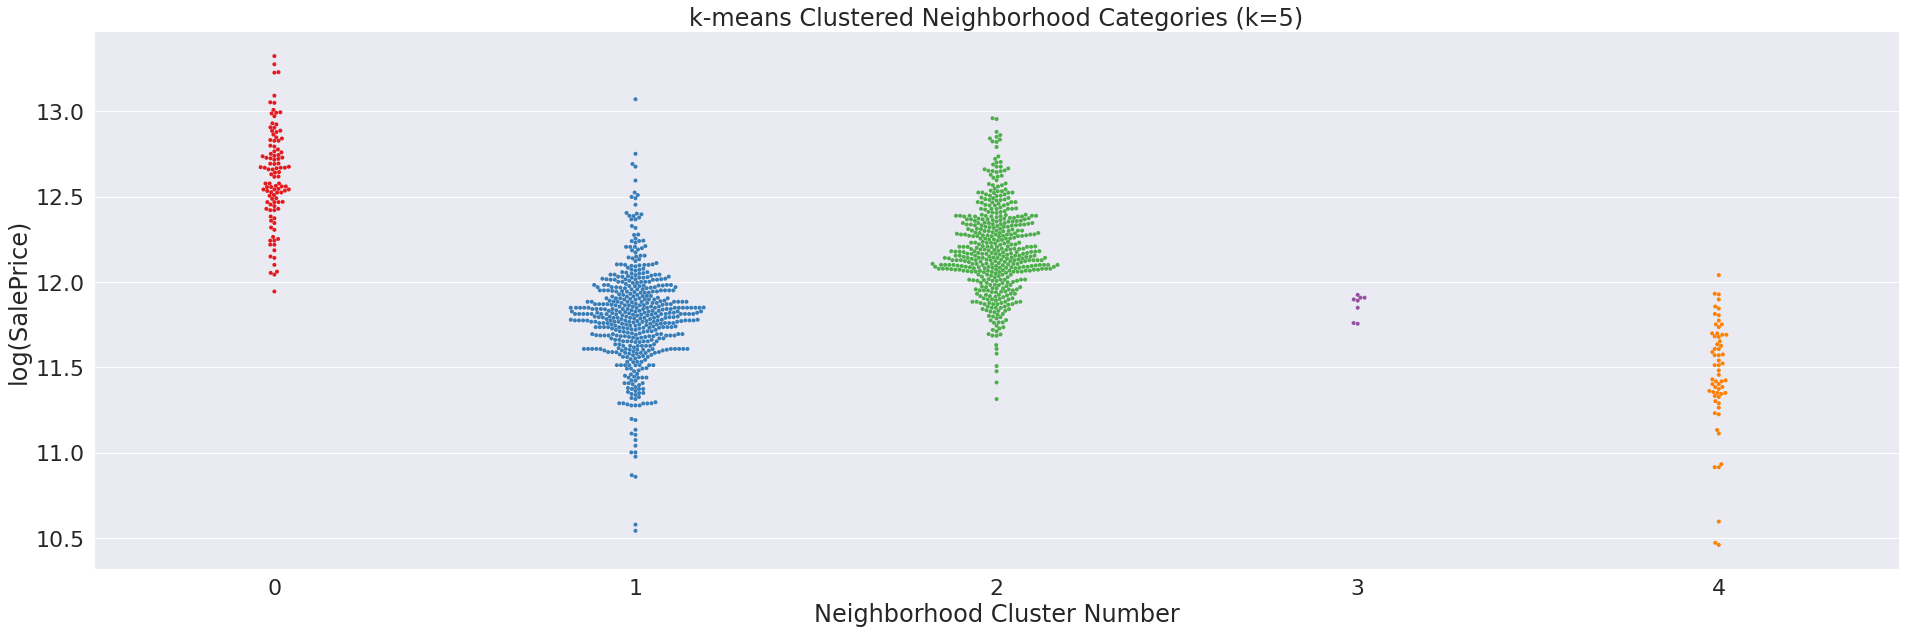

In [58]:
# create swarm plots of the new 'Neighborhood' cluster categories

sns.set(font_scale = 2)  # set font scale

# original categories
chart = sns.catplot(
    data=neighborhoodDF,
    x='Neighborhood', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart.set_xticklabels(rotation=45)
chart.set(title='Original Neighborhood Categories', ylabel='log(SalePrice)')

# chart with k=4 clusters
chart4 = sns.catplot(
    data=nbrHdClusterDF,
    x='nbrHdCluster_k4', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart4.set_xticklabels(rotation=0)
chart4.set(title='k-means Clustered Neighborhood Categories (k=4)')
chart4.set(xlabel='Neighborhood Cluster Number')
chart4.set(ylabel='log(SalePrice)')

# chart with k=5 clusters
chart5 = sns.catplot(
    data=nbrHdClusterDF,
    x='nbrHdCluster_k5', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart5.set(title='k-means Clustered Neighborhood Categories (k=5)')
chart5.set_xticklabels(rotation=0)
chart5.set(xlabel='Neighborhood Cluster Number')
chart5.set(ylabel='log(SalePrice)')

sns.set(font_scale = 1)  # reset font scale

---------------------------------------------------------

**Using k-means clustering to reduce the number of different levels in 'MSSubClass'**

In [59]:
# create new dataframe with dependent and independent variable
msSubClassDF = categoricalDF[['logSalePrice','MSSubClass']].copy()
msSubClassDF.shape

(1166, 2)

In [60]:
# display DF
msSubClassDF.head()

logSalePrice  MSSubClass
1     12.109011          20
2     12.317167          60
3     11.849398          70
4     12.429216          60
5     11.870600          50

In [61]:
# count how many unique categories in variable 'MSSubClass'
nMSSubClass = msSubClassDF['MSSubClass'].nunique()
nMSSubClass

15

In [62]:
# create a Series of the MSSubClass names
msSubClassNames = msSubClassDF['MSSubClass'].unique()

# names of the default descriptive stats (used to create indices of DF below)
#rowNames = ["count","mean","std","min","25%","50%","75%","max"]

# initialize a dataframe to store the SalePrice ($K) statistics of each MSSubClass
msSubClassStatsDF = pd.DataFrame(index=rowNames, columns=msSubClassNames)

# populate the dataframe
for i in range(0, nMSSubClass):
    
    # get the name of a MSSubClass
    msSubClassName = msSubClassNames[i]
    
    # get the rows in msSubClassDF that have this MSSubClass
    rowsWithMSSubClassOfInterestDF = msSubClassDF.loc[msSubClassDF['MSSubClass']==msSubClassName]
    
    # extract the logSalePrice column from this new dataframe
    logSalePricesForThisMSSubClass = rowsWithMSSubClassOfInterestDF['logSalePrice']
    
    # get the descriptive statistics of the logSalePrice for this region
    #  and store statistics as dataframe column
    msSubClassStatsDF.iloc[:,i] = logSalePricesForThisMSSubClass.describe()

In [63]:
# remove the 1st row (counts) from statsDF
msSubClassStatsDF_a = msSubClassStatsDF.iloc[1: , :]

In [64]:
# transpose the dataframe so that categories are the rows
msSubClassStatsDFTrans = msSubClassStatsDF_a.transpose()

In [65]:
# inmpute any missing values (e.g., std deviations of categories with only
#  one variable) with a very low, near-zero value
msSubClassStatsDFTrans = msSubClassStatsDFTrans.fillna(0.000001)
msSubClassStatsDFTrans

mean       std        min        25%        50%        75%  \
20   12.040812  0.383860  10.471950  11.790557  11.969717  12.270220   
60   12.315232  0.263990  11.767568  12.128111  12.277928  12.468437   
70   11.966097  0.379445  10.596635  11.759786  11.951180  12.183301   
50   11.822084  0.355777  10.542706  11.635143  11.794338  11.976659   
190  11.736590  0.270565  10.915088  11.635143  11.786762  11.884489   
45   11.607476  0.173364  11.373663  11.494080  11.585073  11.764638   
90   11.774771  0.208656  11.379394  11.626254  11.820116  11.884489   
120  12.176722  0.281757  11.507913  11.984178  12.170445  12.367341   
30   11.409517  0.282328  10.460242  11.289157  11.492723  11.607781   
85   11.900657  0.127750  11.719940  11.810804  11.877569  11.987169   
80   12.027067  0.205146  11.580584  11.898188  12.028739  12.100712   
160  11.784907  0.279045  11.225243  11.571194  11.891362  12.011273   
75   12.099105  0.469815  11.522876  11.701948  12.052776  12.344522   
180  11.523921  0.273774  11.231888  11.344507  11.418615  11.849398   
40   11.870422  0.486848  11.283512  11.669456  11.864870  12.065836   

           max  
20   13.323927  
60   13.275828  
70   12.791356  
50   12.923912  
190  12.206073  
45   11.845103  
90   12.206073  
120  12.880292  
30   11.877569  
85   12.198544  
80   12.751300  
160  12.384219  
75   13.071070  
180  11.904968  
40   12.468437

In [66]:
# min-max the columns so that all statistic vector elements are weighted equally
msSubClassStatsDFTrans_scaled = MinMaxScaler().fit_transform(msSubClassStatsDFTrans)

In [67]:
# use of k-means to combine MSSubClasses with similar statistics

# determine optimal value for K
distortions = []
inertias = []

K = range(1, nMSSubClass)
for k in K:
    
    # building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(msSubClassStatsDFTrans_scaled)
    kmeanModel.fit(msSubClassStatsDFTrans_scaled)
    
    distortions.append(sum(np.min(cdist(msSubClassStatsDFTrans_scaled,
                kmeanModel.cluster_centers_,'euclidean'),axis=1)) / msSubClassStatsDFTrans_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)

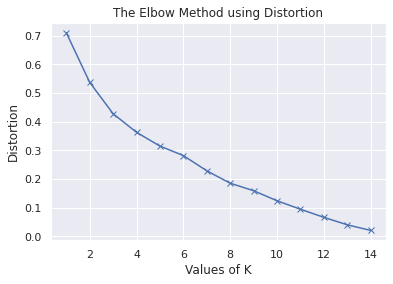

In [68]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

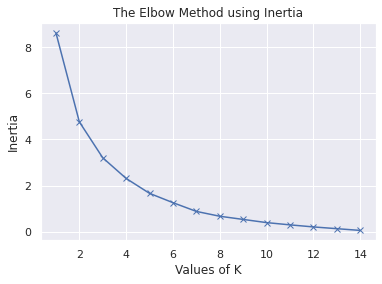

In [69]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

COMMENT:  The elbow curves suggest there is little improvement per additional "k" after about k=4 or k=5 clusters.

In [70]:
# create new dataframe with MSSubClass-related columns
msSubClassClusterDF = msSubClassDF[['logSalePrice','MSSubClass']].copy()

In [71]:
# specify value for k (k=4 clusters in this case)
msSubClass_k = 4

# determine which cluster each MSSubClass belongs to
kmeans = KMeans(n_clusters = msSubClass_k,
        init = 'k-means++',
        random_state = 42)
y_kmeans_msSubClass4 = kmeans.fit_predict(msSubClassStatsDFTrans_scaled)
msSubClassStatsDFTrans['Cluster_4'] = y_kmeans_msSubClass4.tolist()

# create dictionary to map MSSubClass category levels to the corresponding cluster number
msSubClass_clusterNum_Dict_4 = dict(zip(msSubClassStatsDFTrans.index, msSubClassStatsDFTrans.Cluster_4))

# map the cluster numbers to the names of the different category levels
msSubClassClusterDF['msSubClassCluster_k4']=msSubClassClusterDF['MSSubClass'].map(msSubClass_clusterNum_Dict_4)

In [72]:
# specify value for k (k=5 clusters in this case)
msSubClass_k = 5

# determine which cluster each MSSubClass belongs to
kmeans = KMeans(n_clusters = msSubClass_k,
        init = 'k-means++',
        random_state = 42)
y_kmeans_msSubClass5 = kmeans.fit_predict(msSubClassStatsDFTrans_scaled)
msSubClassStatsDFTrans['Cluster_5'] = y_kmeans_msSubClass5.tolist()

# create dictionary to map MSSubClass category levels to the corresponding cluster number
msSubClass_clusterNum_Dict_5 = dict(zip(msSubClassStatsDFTrans.index, msSubClassStatsDFTrans.Cluster_5))

# map the cluster numbers to the names of the different category levels
msSubClassClusterDF['msSubClassCluster_k5']=msSubClassClusterDF['MSSubClass'].map(msSubClass_clusterNum_Dict_5)

-------------------------------

In [73]:
# display the 'MSSubClass' cluster mapping dataframe showing k=4 and k=5 cluster mappings
msSubClassClusterDF.head(10)

logSalePrice  MSSubClass  msSubClassCluster_k4  msSubClassCluster_k5
1      12.109011          20                     3                     3
2      12.317167          60                     1                     2
3      11.849398          70                     3                     3
4      12.429216          60                     1                     2
5      11.870600          50                     3                     3
7      12.206073          60                     1                     2
8      11.774520          50                     3                     3
9      11.678440         190                     0                     4
10     11.771436          20                     3                     3
11     12.751300          60                     1                     2

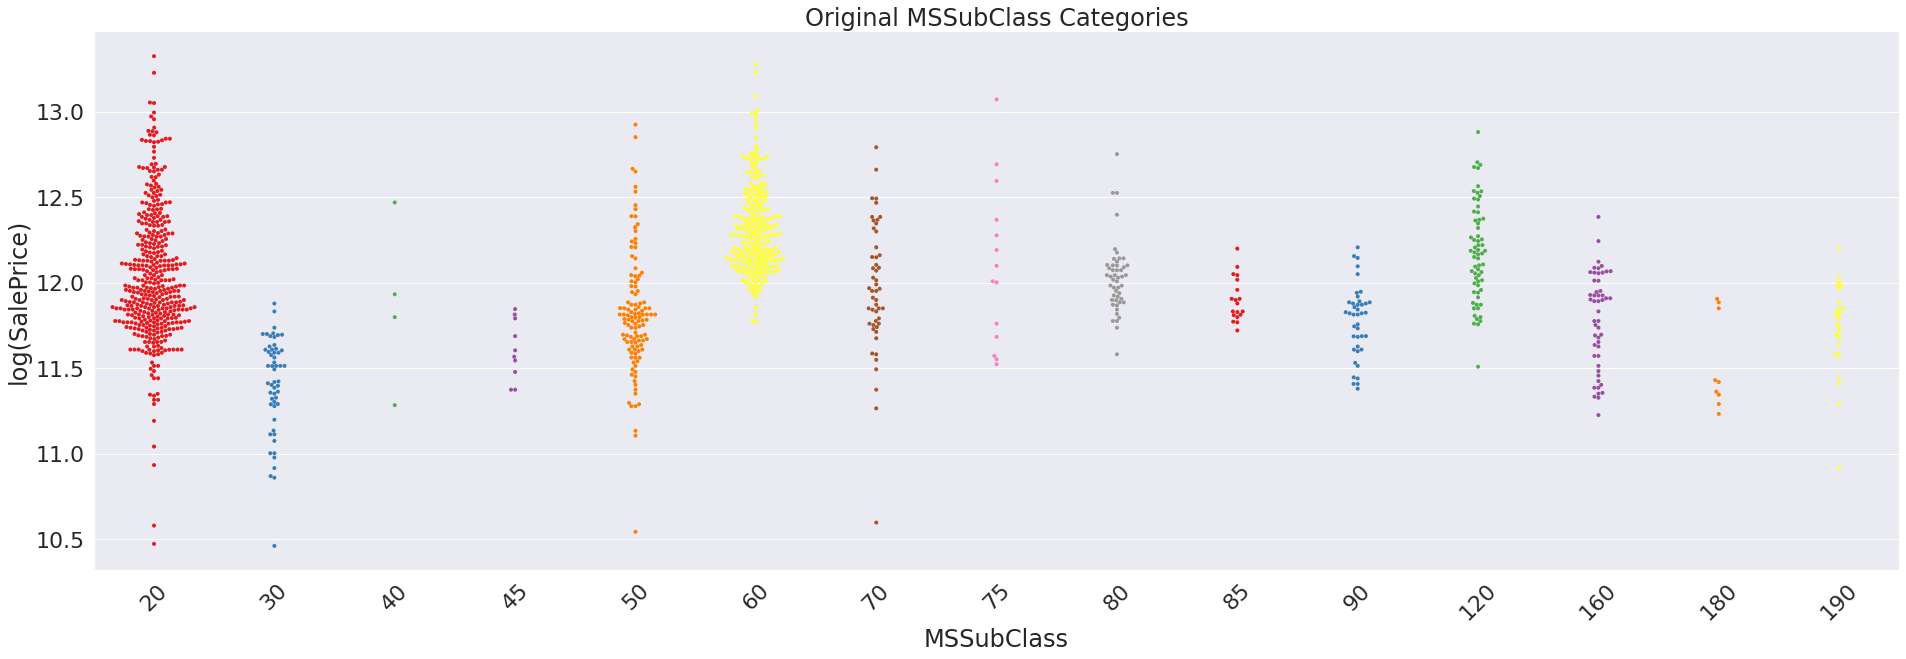

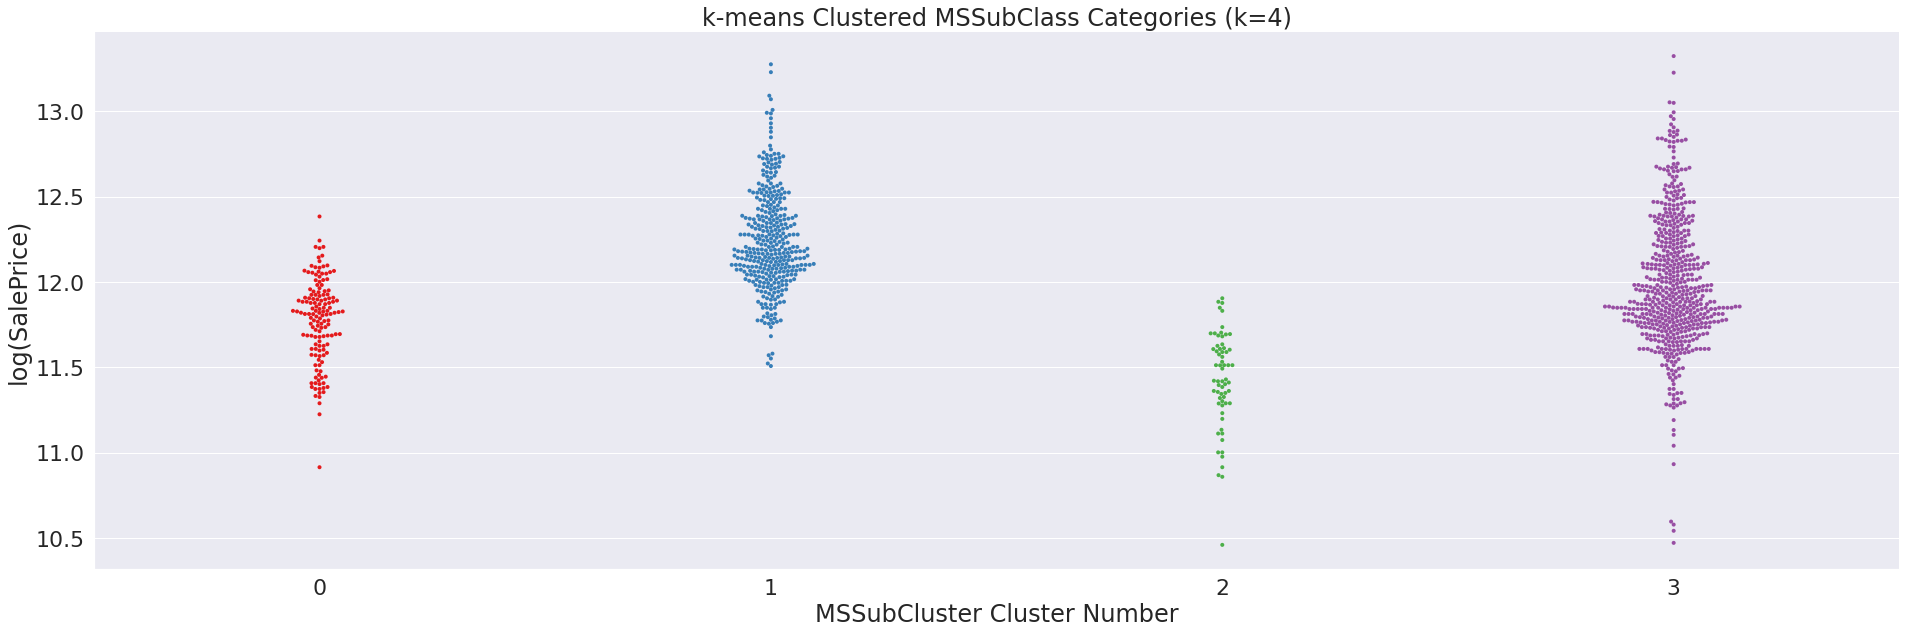

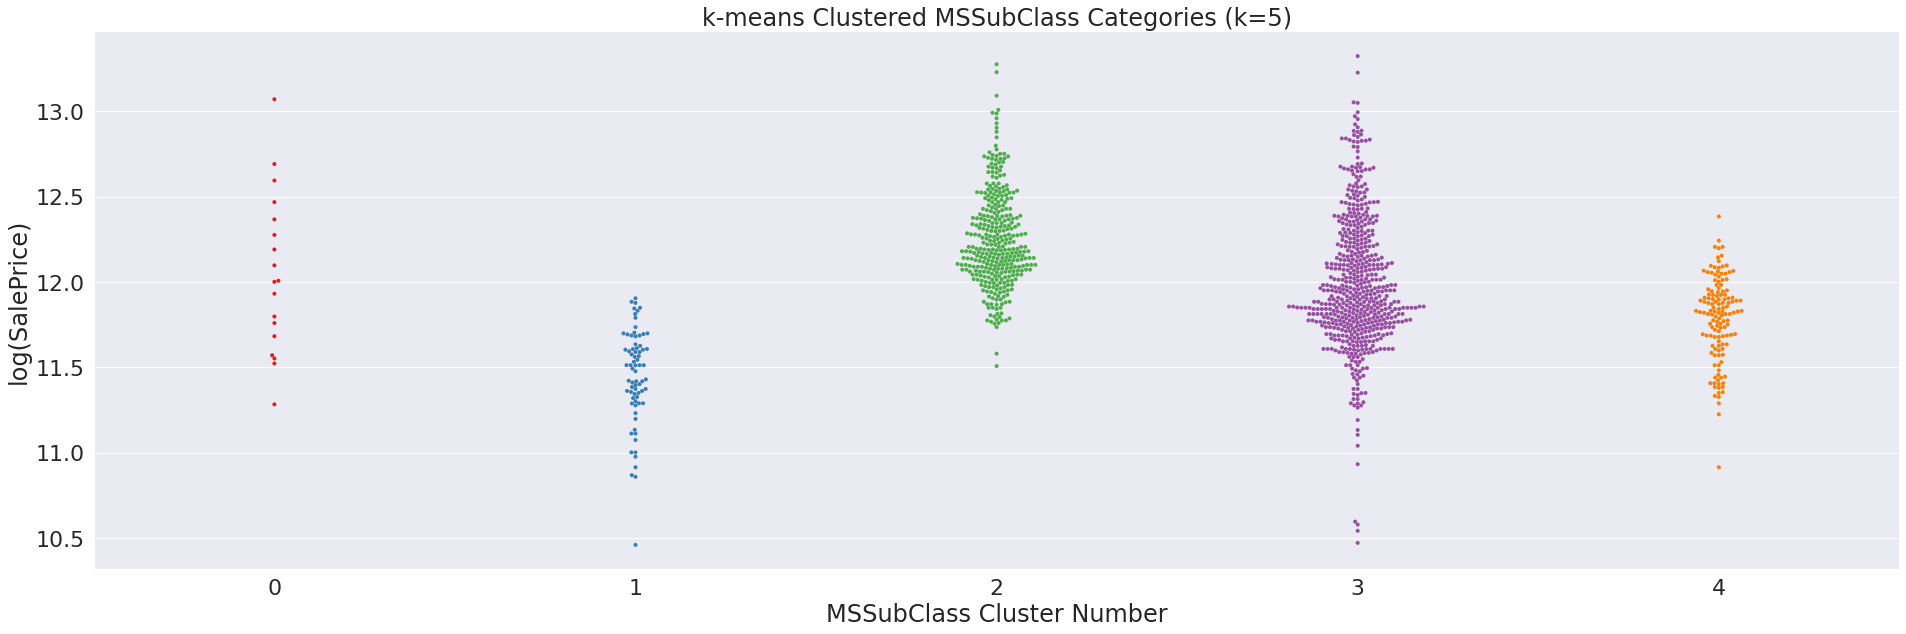

In [74]:
# create swarm plots of the new 'MSSubClass' cluster categories

sns.set(font_scale = 2)  # set font scale

# original categories
chart = sns.catplot(
    data=msSubClassDF,
    x='MSSubClass', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart.set_xticklabels(rotation=45)
chart.set(title='Original MSSubClass Categories', ylabel='log(SalePrice)')

# chart with k=3 clusters
chart4 = sns.catplot(
    data=msSubClassClusterDF,
    x='msSubClassCluster_k4', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart4.set_xticklabels(rotation=0)
chart4.set(title='k-means Clustered MSSubClass Categories (k=4)')
chart4.set(xlabel='MSSubCluster Cluster Number')
chart4.set(ylabel='log(SalePrice)')

# chart with k=5 clusters
chart5 = sns.catplot(
    data=msSubClassClusterDF,
    x='msSubClassCluster_k5', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart5.set(title='k-means Clustered MSSubClass Categories (k=5)')
chart5.set_xticklabels(rotation=0)
chart5.set(xlabel='MSSubClass Cluster Number')
chart5.set(ylabel='log(SalePrice)')

sns.set(font_scale = 1)  # reset font scale

-------------------------------

### DICHOTOMOUS / BINARY VARIABLES

The two dichotomous variables in the data set are 'Street' (Paved vs. Gravel) and 'CentralAir' (Yes/No). Swarmplots were generated for each of these variables to assess whether they should be evaluated further

In [75]:
initBinaryDF = trainDF_a[['logSalePrice','Street','CentralAir']].copy()
initBinaryDF.head()

logSalePrice Street CentralAir
1     12.109011   Pave          Y
2     12.317167   Pave          Y
3     11.849398   Pave          Y
4     12.429216   Pave          Y
5     11.870600   Pave          Y

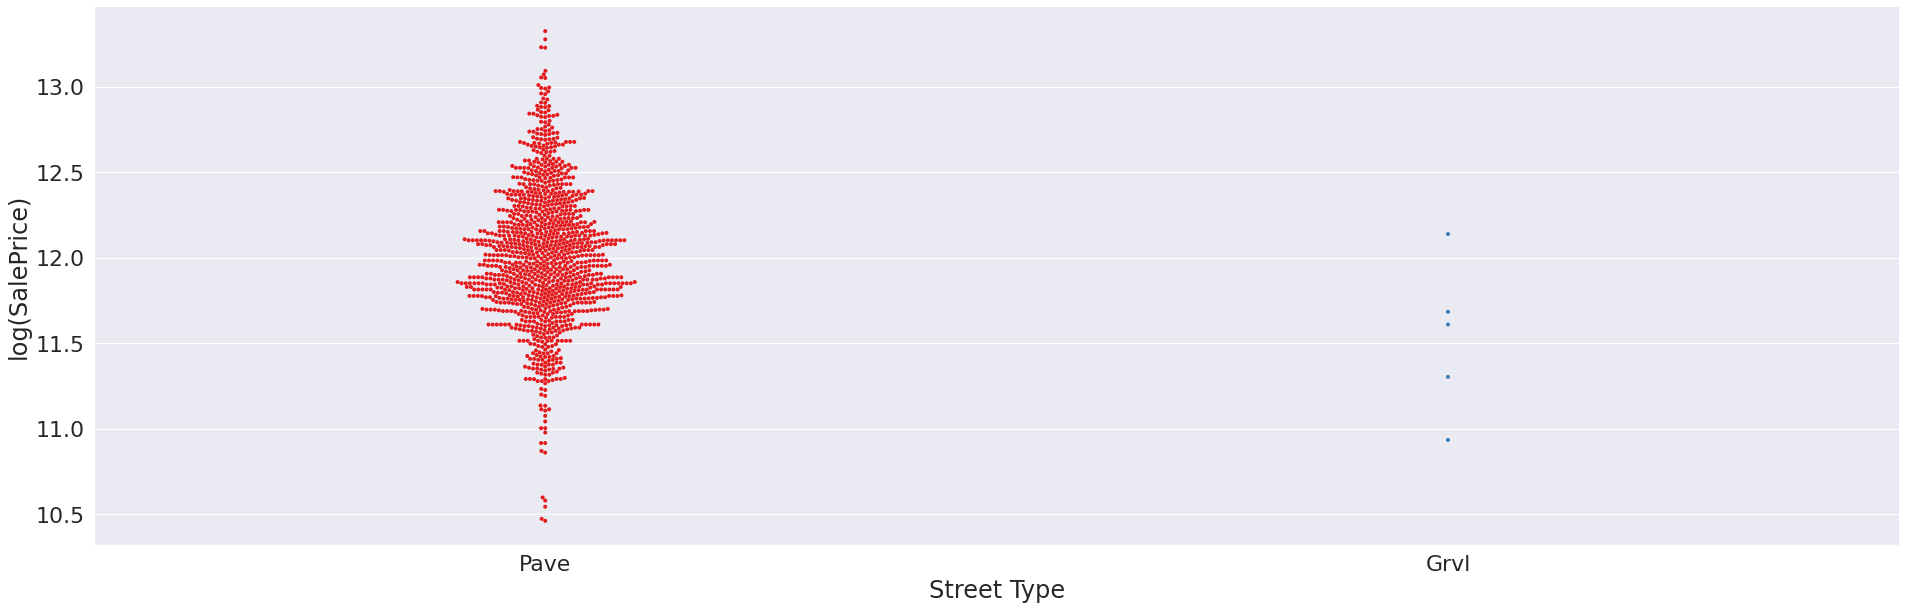

In [76]:
sns.set(font_scale = 2)  # set font scale

# swarmplot for 'Street'
chart = sns.catplot(
    data=initBinaryDF,
    x='Street', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart.set_xticklabels(rotation=0)
chart.set(xlabel='Street Type')
chart.set(ylabel='log(SalePrice)')

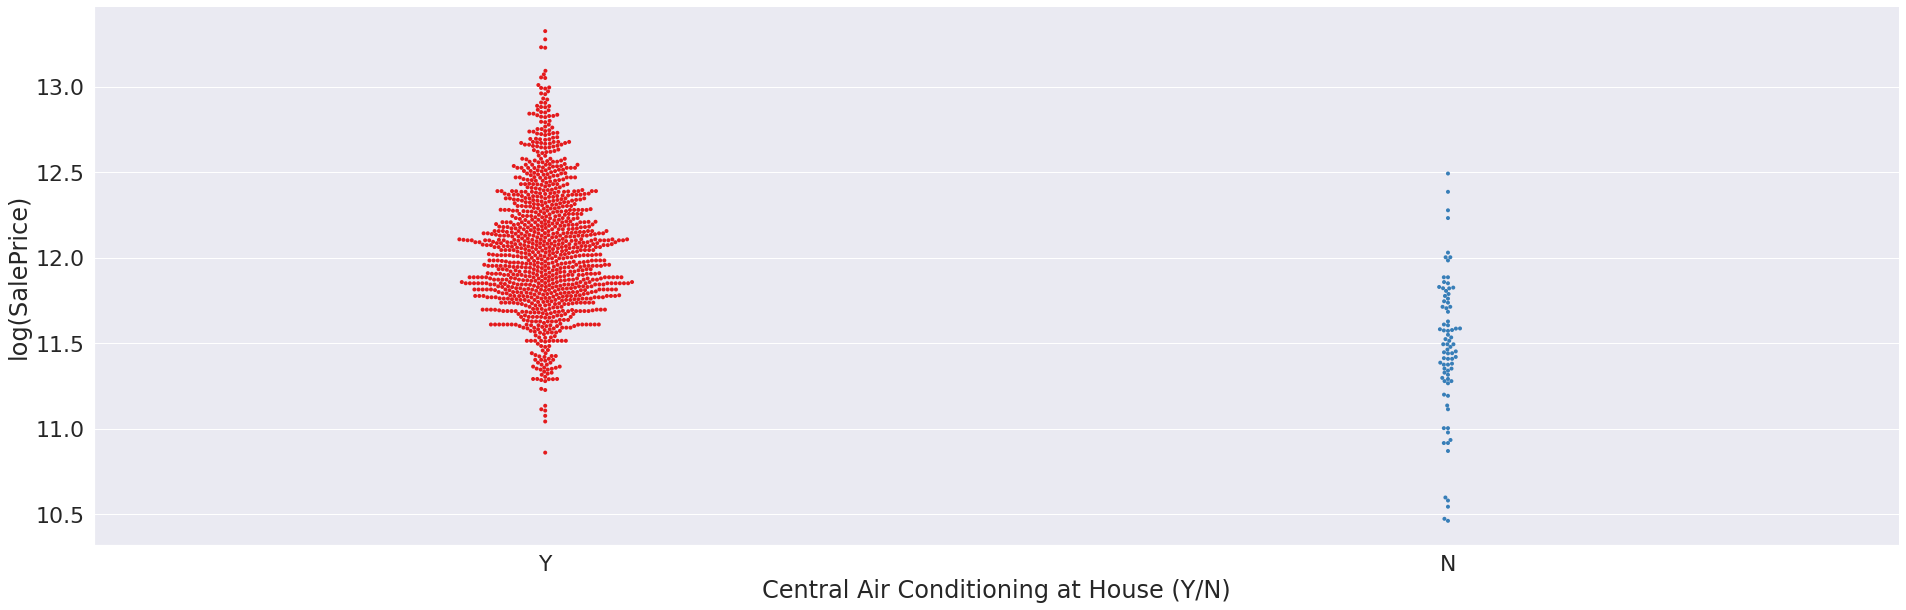

In [77]:
# swarmplot for 'CentralAir'
chart = sns.catplot(
    data=initBinaryDF,
    x='CentralAir', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart.set_xticklabels(rotation=0)
chart.set(xlabel='Central Air Conditioning at House (Y/N)')
chart.set(ylabel='log(SalePrice)')

sns.set(font_scale = 1)  # reset font scale

COMMENT:  The swarmplots show that the vast majority of houses in the Ames, Iowa region are on Paved streets (vs. Gravel).  In addition, most houses possess Central Air Conditioning.

For purposes of including a dichotomous variable in the analysis, the Central Air Conditioning variable will be included.  Note that this variable has to be converted to a (0/1) binary/indicator variable.

-----------------------------------------

### EDA Summary

In the group of continuous variables, 'TotArea' was created and selected for further evaluation, where 
'TotArea' = 'GrLivArea' + 'TotalBsmtSF'.  In addition, samples with 'TotArea' square footage > 7500 sq ft were considered to be outliers and were removed from the dataset.

In the group of discrete/intervallic variables,'YearBuilt' was selected for further evaluation.

In the group of ordinal variables, 'OverallQual' and 'KitchenQual' were selected for further evaluation. The existing rankings for 'OverallQual' in the dataset are integer-based and range from 1 (Very Poor) to 10 (Very Excellent).  The rankings for 'KitchenQual' had to be converted to numeric 1-5 (assuming the quality rankings were sufficiently intervallic), and the resulting variable is named 'KitchenQualNum'.

In the group of non-ordinal, categorical variables, 'Neighborhood' and 'MSSubClass' were selected for further evaluation.  Due to the large number of different categories in these variables, a k-means approach was used to reduce the number of categories to a smaller number of cluster categories, which will eventually be represented by indicator dummy variables when building the regression models.

In the group of (two) dichotomous/binary variables, 'CentralAir' was selected for further evaluation.  Note that the (Y/N) data has to be converted to a (1/0) binary indicator variable.

----------------------------------------------------------------

# MODELING

Create dataframes for the training dataset and validation dataset. For the 'Neighborhood' and 'MSSubClass' variables, the datasets will use the k=5 and k=4 versions, respectively, since the elbow and swarm plots suggest these are good values for k.

In [229]:
# create 'KitchenQualNum' variable for the validation dataset
valDF['KitchenQualNum'] = valDF.loc[:,'KitchenQual'].apply(qualityNames_to_number)

Extract the explanatory variables of interest into training set dataframe and validation set dataframe

In [230]:
init_tDF = trainDF_a[['TotArea','YearBuilt','OverallQual','KitchenQualNum',
                   'Neighborhood','MSSubClass','CentralAir']].copy()
init_tDF = init_tDF[init_tDF['TotArea'] <= 7500]  # ensure high SF outliers are removed
init_tDF['TotArea2'] = init_tDF.TotArea * init_tDF.TotArea
init_tDF['Constant'] = 1

init_vDF = valDF[['TotArea','YearBuilt','OverallQual', 'KitchenQualNum',
                'Neighborhood','MSSubClass','CentralAir']].copy()
init_vDF = init_vDF[init_vDF['TotArea'] <= 7500]  # remove high SF outliers
init_vDF['TotArea2'] = init_vDF.TotArea * init_vDF.TotArea
init_vDF['Constant'] = 1

# show one of the dataframes
init_vDF.head()

TotArea  YearBuilt  OverallQual  KitchenQualNum Neighborhood  MSSubClass  \
0      2566       2003            7               4      CollgCr          60   
6      3380       2004            8               4      Somerst          20   
13     2988       2006            7               4      CollgCr          20   
16     2008       1970            6               3        NAmes          20   
20     3534       2005            8               4      NridgHt          60   

   CentralAir  TotArea2  Constant  
0           Y   6584356         1  
6           Y  11424400         1  
13          Y   8928144         1  
16          Y   4032064         1  
20          Y  12489156         1

Convert the 'CentralAir' Y/N values to binary (1/0)

In [231]:
# initialize new columns
init_tDF['CentAir'] = 0
init_vDF['CentAir'] = 0

# substitute binary values for (Y/N) values
init_tDF['CentAir'] = np.where(
    init_tDF['CentralAir'] == 'N', 0, np.where(
    init_tDF['CentralAir'] == 'Y', 1, -1))

init_vDF['CentAir'] = np.where(
    init_vDF['CentralAir'] == 'N', 0, np.where(
    init_vDF['CentralAir'] == 'Y', 1, -1))

# remove 'CentralAir' variable to cleanup dataframes
init_tDF = init_tDF.drop(columns = ['CentralAir'])
init_vDF = init_vDF.drop(columns = ['CentralAir'])

--------------------------------

Address non-numeric categorical variables that require dummy variables

In [232]:
# create temporary dataframes for variables that have to be converted to dummy indicator variables
#   and map the cluster numbers to the appropriate category names
tDF_dummy = init_tDF[['Neighborhood','MSSubClass']].copy()
vDF_dummy = init_vDF[['Neighborhood','MSSubClass']].copy()

tDF_dummy['NbrHdCluster'] = tDF_dummy['Neighborhood'].map(nbrHd_clusterNum_Dict_5)
vDF_dummy['NbrHdCluster'] = vDF_dummy['Neighborhood'].map(nbrHd_clusterNum_Dict_5)

tDF_dummy['MSSubClassCluster'] = tDF_dummy['MSSubClass'].map(msSubClass_clusterNum_Dict_4)
vDF_dummy['MSSubClassCluster'] = vDF_dummy['MSSubClass'].map(msSubClass_clusterNum_Dict_4)

In [233]:
# obtain median values in the training data cluster numbers for possible imputation of missing values
nbrHd_cluster_median = tDF_dummy.NbrHdCluster.median
msSubClass_cluster_median = tDF_dummy.MSSubClassCluster.median

Check the dataframes (especially the validation dataset) for missing values

In [234]:
# training dataset Neighborhood clusters
tDF_dummy.isnull().sum()

Neighborhood         0
MSSubClass           0
NbrHdCluster         0
MSSubClassCluster    0
dtype: int64

In [235]:
# validation dataset Neighborhood clusters
vDF_dummy.isnull().sum()

Neighborhood         0
MSSubClass           0
NbrHdCluster         0
MSSubClassCluster    0
dtype: int64

In [236]:
# identify any rows with null values
is_NaN = tDF_dummy.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = tDF_dummy[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [Neighborhood, MSSubClass, NbrHdCluster, MSSubClassCluster]
Index: []


In [237]:
# identify any rows with null values
is_NaN = vDF_dummy.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = vDF_dummy[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [Neighborhood, MSSubClass, NbrHdCluster, MSSubClassCluster]
Index: []


Impute any missing values in the cluster numbers with the median

In [238]:
# obtain median values in the training data cluster numbers for possible imputation of missing values
nbrHd_cluster_median = int(tDF_dummy['NbrHdCluster'].median())
msSubClass_cluster_median = int(tDF_dummy['MSSubClassCluster'].median())

print('The median of the Neighborhood cluster numbers =', nbrHd_cluster_median)
print('The median of the MSSubClass cluster numbers =', msSubClass_cluster_median)

# fill any missing values with median, and ensure the columns are integers
tDF_dummy['NbrHdCluster'].fillna(int(nbrHd_cluster_median), inplace=True)
vDF_dummy['NbrHdCluster'].fillna(int(nbrHd_cluster_median), inplace=True)
tDF_dummy['NbrHdCluster'] = tDF_dummy['NbrHdCluster'].astype(int)
vDF_dummy['NbrHdCluster'] = vDF_dummy['NbrHdCluster'].astype(int)

tDF_dummy['MSSubClassCluster'].fillna(msSubClass_cluster_median, inplace=True)
vDF_dummy['MSSubClassCluster'].fillna(msSubClass_cluster_median, inplace=True)
tDF_dummy['MSSubClassCluster'] = tDF_dummy['MSSubClassCluster'].astype(int)
vDF_dummy['MSSubClassCluster'] = vDF_dummy['MSSubClassCluster'].astype(int)

The median of the Neighborhood cluster numbers = 1
The median of the MSSubClass cluster numbers = 3


Check the data frames again to make sure there are no missing values (especially with the previously-unseen, validation data)

In [239]:
# training dataset cluster number variables
tDF_dummy.isnull().sum()

Neighborhood         0
MSSubClass           0
NbrHdCluster         0
MSSubClassCluster    0
dtype: int64

In [240]:
# validation dataset cluster number variables
vDF_dummy.isnull().sum()

Neighborhood         0
MSSubClass           0
NbrHdCluster         0
MSSubClassCluster    0
dtype: int64

In [241]:
tDF_dummy.head(10)

Neighborhood  MSSubClass  NbrHdCluster  MSSubClassCluster
1       Veenker          20             2                  3
2       CollgCr          60             2                  1
3       Crawfor          70             2                  3
4       NoRidge          60             0                  1
5       Mitchel          50             1                  3
7        NWAmes          60             2                  1
8       OldTown          50             1                  3
9       BrkSide         190             1                  0
10       Sawyer          20             1                  3
11      NridgHt          60             0                  1

In [242]:
vDF_dummy.head(10)

Neighborhood  MSSubClass  NbrHdCluster  MSSubClassCluster
0       CollgCr          60             2                  1
6       Somerst          20             2                  3
13      CollgCr          20             2                  3
16        NAmes          20             1                  3
20      NridgHt          60             0                  1
31       Sawyer          20             1                  3
32      CollgCr          20             2                  3
39      Edwards          90             1                  0
67      CollgCr          20             2                  3
70        NAmes          20             1                  3

Create indicator variables to represent the different cluster numbers in the dataframes.

In [243]:
# create indicator dummy variables for the 'Neighborhood' clusters
trainNbrHdDummies = pd.DataFrame(pd.get_dummies(data=tDF_dummy.NbrHdCluster,
                              prefix='nbrHdCluster', drop_first=True))
valNbrHdDummies = pd.DataFrame(pd.get_dummies(data=vDF_dummy.NbrHdCluster,
                              prefix='nbrHdCluster', drop_first=True))

In [244]:
trainNbrHdDummies.head(10)

nbrHdCluster_1  nbrHdCluster_2  nbrHdCluster_3  nbrHdCluster_4
1                0               1               0               0
2                0               1               0               0
3                0               1               0               0
4                0               0               0               0
5                1               0               0               0
7                0               1               0               0
8                1               0               0               0
9                1               0               0               0
10               1               0               0               0
11               0               0               0               0

In [245]:
valNbrHdDummies.head(10)

nbrHdCluster_1  nbrHdCluster_2  nbrHdCluster_3  nbrHdCluster_4
0                0               1               0               0
6                0               1               0               0
13               0               1               0               0
16               1               0               0               0
20               0               0               0               0
31               1               0               0               0
32               0               1               0               0
39               1               0               0               0
67               0               1               0               0
70               1               0               0               0

In [246]:
# create indicator dummy variables for the 'MSSubClass' clusters
trainMSSubClassDummies = pd.DataFrame(pd.get_dummies(data=tDF_dummy.MSSubClassCluster,
                              prefix='msSubClassCluster', drop_first=True))

valMSSubClassDummies = pd.DataFrame(pd.get_dummies(data=vDF_dummy.MSSubClassCluster,
                              prefix='msSubClassCluster', drop_first=True))

Add the indicator variables to the dataframes.

In [247]:
# add the 'Neighborhood' cluster indicator dummy variables

tDF_dummy['NbrHd_Grp1'] = trainNbrHdDummies.nbrHdCluster_1
tDF_dummy['NbrHd_Grp2'] = trainNbrHdDummies.nbrHdCluster_2
tDF_dummy['NbrHd_Grp3'] = trainNbrHdDummies.nbrHdCluster_3
tDF_dummy['NbrHd_Grp4'] = trainNbrHdDummies.nbrHdCluster_4

vDF_dummy['NbrHd_Grp1'] = valNbrHdDummies.nbrHdCluster_1
vDF_dummy['NbrHd_Grp2'] = valNbrHdDummies.nbrHdCluster_2
vDF_dummy['NbrHd_Grp3'] = valNbrHdDummies.nbrHdCluster_3
vDF_dummy['NbrHd_Grp4'] = valNbrHdDummies.nbrHdCluster_4

In [248]:
# add the 'MSSubClass'' cluster indicator dummy variables

tDF_dummy['MSSubClass_Grp1'] = trainMSSubClassDummies.msSubClassCluster_1
tDF_dummy['MSSubClass_Grp2'] = trainMSSubClassDummies.msSubClassCluster_2
tDF_dummy['MSSubClass_Grp3'] = trainMSSubClassDummies.msSubClassCluster_3

vDF_dummy['MSSubClass_Grp1'] = valMSSubClassDummies.msSubClassCluster_1
vDF_dummy['MSSubClass_Grp2'] = valMSSubClassDummies.msSubClassCluster_2
vDF_dummy['MSSubClass_Grp3'] = valMSSubClassDummies.msSubClassCluster_3

In [249]:
tDF_dummy.head(10)

Neighborhood  MSSubClass  NbrHdCluster  MSSubClassCluster  NbrHd_Grp1  \
1       Veenker          20             2                  3           0   
2       CollgCr          60             2                  1           0   
3       Crawfor          70             2                  3           0   
4       NoRidge          60             0                  1           0   
5       Mitchel          50             1                  3           1   
7        NWAmes          60             2                  1           0   
8       OldTown          50             1                  3           1   
9       BrkSide         190             1                  0           1   
10       Sawyer          20             1                  3           1   
11      NridgHt          60             0                  1           0   

    NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  MSSubClass_Grp1  MSSubClass_Grp2  \
1            1           0           0                0                0   
2            1           0           0                1                0   
3            1           0           0                0                0   
4            0           0           0                1                0   
5            0           0           0                0                0   
7            1           0           0                1                0   
8            0           0           0                0                0   
9            0           0           0                0                0   
10           0           0           0                0                0   
11           0           0           0                1                0   

    MSSubClass_Grp3  
1                 1  
2                 0  
3                 1  
4                 0  
5                 1  
7                 0  
8                 1  
9                 0  
10                1  
11                0

In [250]:
vDF_dummy.head(10)

Neighborhood  MSSubClass  NbrHdCluster  MSSubClassCluster  NbrHd_Grp1  \
0       CollgCr          60             2                  1           0   
6       Somerst          20             2                  3           0   
13      CollgCr          20             2                  3           0   
16        NAmes          20             1                  3           1   
20      NridgHt          60             0                  1           0   
31       Sawyer          20             1                  3           1   
32      CollgCr          20             2                  3           0   
39      Edwards          90             1                  0           1   
67      CollgCr          20             2                  3           0   
70        NAmes          20             1                  3           1   

    NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  MSSubClass_Grp1  MSSubClass_Grp2  \
0            1           0           0                1                0   
6            1           0           0                0                0   
13           1           0           0                0                0   
16           0           0           0                0                0   
20           0           0           0                1                0   
31           0           0           0                0                0   
32           1           0           0                0                0   
39           0           0           0                0                0   
67           1           0           0                0                0   
70           0           0           0                0                0   

    MSSubClass_Grp3  
0                 0  
6                 1  
13                1  
16                1  
20                0  
31                1  
32                1  
39                0  
67                1  
70                1

--------------------------------------

Address variables that have to be Min-Max scaled

In [251]:
# create temporary dataframes for variables that have to be converted to dummy indicator variables
#   and map the cluster numbers to the appropriate category names
tDF_minMax = init_tDF[['TotArea','TotArea2','YearBuilt','OverallQual','KitchenQualNum']].copy()
vDF_minMax = init_vDF[['TotArea','TotArea2','YearBuilt','OverallQual','KitchenQualNum']].copy()
tDF_minMax_nRows = tDF_minMax.shape[0]
vDF_minMax_nRows = vDF_minMax.shape[0]
print('The training min-max dataframe has', tDF_minMax_nRows, 'rows.')
print('The validation min-max dataframe has', vDF_minMax_nRows, 'rows.')

# create columns consisting of the indices
tDF_minMax['OrigIndex'] = tDF_minMax.index
vDF_minMax['OrigIndex'] = vDF_minMax.index

# append the validation data to the training data
origTrainDF_minMax = tDF_minMax.copy()
origTrainDF_minMax = origTrainDF_minMax.append(vDF_minMax, ignore_index=False)
origTrainDF_minMax_nRows = origTrainDF_minMax.shape[0]
print('The combined min-max dataframe has', origTrainDF_minMax_nRows, 'rows.\n')
origTrainDF_minMax.head(15)

The training min-max dataframe has 1166 rows.
The validation min-max dataframe has 292 rows.
The combined min-max dataframe has 1458 rows.



TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  OrigIndex
1      2524   6370576       1976            6               3          1
2      2706   7322436       2001            7               4          2
3      2473   6115729       1915            7               4          3
4      3343  11175649       2000            8               4          4
5      2158   4656964       1993            5               3          5
7      3197  10220809       1973            7               3          7
8      2726   7431076       1931            7               3          8
9      2068   4276624       1939            5               3          9
10     2080   4326400       1965            5               3         10
11     3499  12243001       2005            9               5         11
12     1824   3326976       1962            5               3         12
14     2506   6280036       1960            6               3         14
15     1686   2842596       1929            7               3         15
17     1296   1679616       1967            4               3         17
18     2228   4963984       2004            5               4         18

In [252]:
# perform Min-Max scaling on the combined data
def min_max_scale(df):
  mins = df.min()
  maxs = df.max()
  ranges = maxs-mins
  return (df - mins)/ranges

# use apply() to min-max all columns except OrigIndex column
origTrainDF_minMax = origTrainDF_minMax.apply(lambda x: min_max_scale(x)
 if x.name in ['TotArea', 'TotArea2','YearBuilt','OverallQual','KitchenQualNum'] else x)

origTrainDF_minMax.head(10)

TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  OrigIndex
1   0.334965  0.132852   0.753623     0.555556        0.333333          1
2   0.362802  0.153056   0.934783     0.666667        0.666667          2
3   0.327164  0.127442   0.311594     0.666667        0.666667          3
4   0.460232  0.234842   0.927536     0.777778        0.666667          4
5   0.278984  0.096479   0.876812     0.444444        0.333333          5
7   0.437901  0.214575   0.731884     0.666667        0.333333          7
8   0.365861  0.155362   0.427536     0.666667        0.333333          8
9   0.265219  0.088406   0.485507     0.444444        0.333333          9
10  0.267054  0.089463   0.673913     0.444444        0.333333         10
11  0.484093  0.257498   0.963768     0.888889        1.000000         11

In [253]:
origTrainDF_minMax.set_index('OrigIndex')
origTrainDF_minMax.head(10)

TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  OrigIndex
1   0.334965  0.132852   0.753623     0.555556        0.333333          1
2   0.362802  0.153056   0.934783     0.666667        0.666667          2
3   0.327164  0.127442   0.311594     0.666667        0.666667          3
4   0.460232  0.234842   0.927536     0.777778        0.666667          4
5   0.278984  0.096479   0.876812     0.444444        0.333333          5
7   0.437901  0.214575   0.731884     0.666667        0.333333          7
8   0.365861  0.155362   0.427536     0.666667        0.333333          8
9   0.265219  0.088406   0.485507     0.444444        0.333333          9
10  0.267054  0.089463   0.673913     0.444444        0.333333         10
11  0.484093  0.257498   0.963768     0.888889        1.000000         11

In [254]:
print('\nThe Min-Max scaled data statistics are as follows:\n')
origTrainDF_minMax.describe() # check Min-Max scaling


The Min-Max scaled data statistics are as follows:



TotArea     TotArea2    YearBuilt  OverallQual  KitchenQualNum  \
count  1458.000000  1458.000000  1458.000000  1458.000000     1458.000000   
mean      0.340930     0.149842     0.718972     0.565996        0.503201   
std       0.118719     0.097545     0.218795     0.152930        0.220640   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.256959     0.083728     0.594203     0.444444        0.333333   
50%       0.327700     0.127810     0.728261     0.555556        0.333333   
75%       0.408611     0.189364     0.927536     0.666667        0.666667   
max       1.000000     1.000000     1.000000     1.000000        1.000000   

         OrigIndex  
count  1458.000000  
mean    729.251715  
std     421.601532  
min       0.000000  
25%     364.250000  
50%     729.500000  
75%    1093.750000  
max    1459.000000

In [255]:
# split the Min-Max scaled values into scaled training and validation dataframes
tDF_minMax_scaled = origTrainDF_minMax.iloc[0:tDF_minMax_nRows,]
vDF_minMax_scaled = origTrainDF_minMax.iloc[tDF_minMax_nRows:origTrainDF_minMax_nRows,]

print('The scaled tDF has',tDF_minMax_scaled.shape[0],'rows.')
print('The scaled vDF has',vDF_minMax_scaled.shape[0],'rows.')

The scaled tDF has 1166 rows.
The scaled vDF has 292 rows.


In [256]:
tDF_minMax_scaled.head(10)

TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  OrigIndex
1   0.334965  0.132852   0.753623     0.555556        0.333333          1
2   0.362802  0.153056   0.934783     0.666667        0.666667          2
3   0.327164  0.127442   0.311594     0.666667        0.666667          3
4   0.460232  0.234842   0.927536     0.777778        0.666667          4
5   0.278984  0.096479   0.876812     0.444444        0.333333          5
7   0.437901  0.214575   0.731884     0.666667        0.333333          7
8   0.365861  0.155362   0.427536     0.666667        0.333333          8
9   0.265219  0.088406   0.485507     0.444444        0.333333          9
10  0.267054  0.089463   0.673913     0.444444        0.333333         10
11  0.484093  0.257498   0.963768     0.888889        1.000000         11

In [257]:
vDF_minMax_scaled.head(10)

TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  OrigIndex
0   0.341389  0.137389   0.949275     0.666667        0.666667          0
6   0.465892  0.240122   0.956522     0.777778        0.666667          6
13  0.405935  0.187138   0.971014     0.666667        0.666667         13
16  0.256042  0.083215   0.710145     0.555556        0.333333         16
20  0.489446  0.262723   0.963768     0.777778        0.666667         20
31  0.324564  0.125664   0.681159     0.444444        0.666667         31
32  0.326400  0.126918   0.978261     0.777778        0.666667         32
39  0.125115  0.025801   0.601449     0.333333        0.000000         39
67  0.397369  0.180101   0.949275     0.666667        0.666667         67
70  0.628939  0.417198   0.731884     0.666667        0.333333         70

Reconstruct the data frames with the Min-Max scaled variables and the dummy indicator variables

In [258]:
tDF = init_tDF[['Constant']].copy()
tDF['TotArea'] = tDF_minMax_scaled['TotArea']
tDF['TotArea2'] = tDF_minMax_scaled['TotArea2']
tDF['YearBuilt'] = tDF_minMax_scaled['YearBuilt']
tDF['OverallQual'] = tDF_minMax_scaled['OverallQual']
tDF['KitchenQualNum'] = tDF_minMax_scaled['KitchenQualNum']
tDF['CentAir'] = init_tDF['CentAir']
tDF['NbrHd_Grp1'] = tDF_dummy.NbrHd_Grp1
tDF['NbrHd_Grp2'] = tDF_dummy.NbrHd_Grp2
tDF['NbrHd_Grp3'] = tDF_dummy.NbrHd_Grp3
tDF['NbrHd_Grp4'] = tDF_dummy.NbrHd_Grp4
tDF['MSSubClass_Grp1'] = tDF_dummy.MSSubClass_Grp1
tDF['MSSubClass_Grp2'] = tDF_dummy.MSSubClass_Grp2
tDF['MSSubClass_Grp3'] = tDF_dummy.MSSubClass_Grp3

vDF = init_vDF[['Constant']].copy()
vDF['TotArea'] = vDF_minMax_scaled['TotArea']
vDF['TotArea2'] = vDF_minMax_scaled['TotArea2']
vDF['YearBuilt'] = vDF_minMax_scaled['YearBuilt']
vDF['OverallQual'] = vDF_minMax_scaled['OverallQual']
vDF['KitchenQualNum'] = vDF_minMax_scaled['KitchenQualNum']
vDF['CentAir'] = init_vDF['CentAir']
vDF['NbrHd_Grp1'] = vDF_dummy.NbrHd_Grp1
vDF['NbrHd_Grp2'] = vDF_dummy.NbrHd_Grp2
vDF['NbrHd_Grp3'] = vDF_dummy.NbrHd_Grp3
vDF['NbrHd_Grp4'] = vDF_dummy.NbrHd_Grp4
vDF['MSSubClass_Grp1'] = vDF_dummy.MSSubClass_Grp1
vDF['MSSubClass_Grp2'] = vDF_dummy.MSSubClass_Grp2
vDF['MSSubClass_Grp3'] = vDF_dummy.MSSubClass_Grp3

In [259]:
tDF.head(10)

Constant   TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  \
1          1  0.334965  0.132852   0.753623     0.555556        0.333333   
2          1  0.362802  0.153056   0.934783     0.666667        0.666667   
3          1  0.327164  0.127442   0.311594     0.666667        0.666667   
4          1  0.460232  0.234842   0.927536     0.777778        0.666667   
5          1  0.278984  0.096479   0.876812     0.444444        0.333333   
7          1  0.437901  0.214575   0.731884     0.666667        0.333333   
8          1  0.365861  0.155362   0.427536     0.666667        0.333333   
9          1  0.265219  0.088406   0.485507     0.444444        0.333333   
10         1  0.267054  0.089463   0.673913     0.444444        0.333333   
11         1  0.484093  0.257498   0.963768     0.888889        1.000000   

    CentAir  NbrHd_Grp1  NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  MSSubClass_Grp1  \
1         1           0           1           0           0                0   
2         1           0           1           0           0                1   
3         1           0           1           0           0                0   
4         1           0           0           0           0                1   
5         1           1           0           0           0                0   
7         1           0           1           0           0                1   
8         1           1           0           0           0                0   
9         1           1           0           0           0                0   
10        1           1           0           0           0                0   
11        1           0           0           0           0                1   

    MSSubClass_Grp2  MSSubClass_Grp3  
1                 0                1  
2                 0                0  
3                 0                1  
4                 0                0  
5                 0                1  
7                 0                0  
8                 0                1  
9                 0                0  
10                0                1  
11                0                0

In [260]:
vDF.head(10)

Constant   TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  \
0          1  0.341389  0.137389   0.949275     0.666667        0.666667   
6          1  0.465892  0.240122   0.956522     0.777778        0.666667   
13         1  0.405935  0.187138   0.971014     0.666667        0.666667   
16         1  0.256042  0.083215   0.710145     0.555556        0.333333   
20         1  0.489446  0.262723   0.963768     0.777778        0.666667   
31         1  0.324564  0.125664   0.681159     0.444444        0.666667   
32         1  0.326400  0.126918   0.978261     0.777778        0.666667   
39         1  0.125115  0.025801   0.601449     0.333333        0.000000   
67         1  0.397369  0.180101   0.949275     0.666667        0.666667   
70         1  0.628939  0.417198   0.731884     0.666667        0.333333   

    CentAir  NbrHd_Grp1  NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  MSSubClass_Grp1  \
0         1           0           1           0           0                1   
6         1           0           1           0           0                0   
13        1           0           1           0           0                0   
16        1           1           0           0           0                0   
20        1           0           0           0           0                1   
31        1           1           0           0           0                0   
32        1           0           1           0           0                0   
39        0           1           0           0           0                0   
67        1           0           1           0           0                0   
70        1           1           0           0           0                0   

    MSSubClass_Grp2  MSSubClass_Grp3  
0                 0                0  
6                 0                1  
13                0                1  
16                0                1  
20                0                0  
31                0                1  
32                0                1  
39                0                0  
67                0                1  
70                0                1

----------------------------------------

**Create and evaluate NON-REGULARIZED model:**

In [417]:
tModel = sm.OLS(trainDF_a.logSalePrice, tDF).fit()
tPredictions = tModel.predict(tDF)
print('The model coefficients are:\n')
print(tModel.params)

tError = np.exp(trainDF_a.logSalePrice) - np.exp(tPredictions)
tSqError = tError * tError
mse = tSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((trainDF_a.logSalePrice).corr(tPredictions))**2

print('\nThe R2 value using the TRAINING dataset =', predR2)
print('The RMSE using the TRAINING dataset =', rmse)

The model coefficients are:

Constant           10.848936
TotArea             1.636853
TotArea2           -0.176973
YearBuilt           0.135287
OverallQual         0.675426
KitchenQualNum      0.173864
CentAir             0.153302
NbrHd_Grp1         -0.138828
NbrHd_Grp2         -0.063131
NbrHd_Grp3         -0.153050
NbrHd_Grp4         -0.287908
MSSubClass_Grp1     0.066773
MSSubClass_Grp2    -0.064457
MSSubClass_Grp3     0.036106
dtype: float64

The R2 using the TRAINING dataset = 0.8661339126184616
The RMSE using the TRAINING dataset = 27219.864070710868


In [418]:
# validation dataset, prediction results
vPredictions = tModel.predict(vDF)

vError = np.exp(valDF.logSalePrice) - np.exp(vPredictions)
vSqError = vError * vError
mse = vSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((valDF.logSalePrice).corr(vPredictions))**2
print('The R2 value using the VALIDATION dataset =', predR2)
print('The RMSE using the VALIDATION dataset =', rmse)

The R2 value using the VALIDATION dataset = 0.8711137215293271
The RMSE using the VALIDATION dataset = 27297.379003616326


--------------------------------------------

In [263]:
trainDF_a.logSalePrice.head(10)

1     12.109011
2     12.317167
3     11.849398
4     12.429216
5     11.870600
7     12.206073
8     11.774520
9     11.678440
10    11.771436
11    12.751300
Name: logSalePrice, dtype: float64

In [264]:
tDF.head(10)

Constant   TotArea  TotArea2  YearBuilt  OverallQual  KitchenQualNum  \
1          1  0.334965  0.132852   0.753623     0.555556        0.333333   
2          1  0.362802  0.153056   0.934783     0.666667        0.666667   
3          1  0.327164  0.127442   0.311594     0.666667        0.666667   
4          1  0.460232  0.234842   0.927536     0.777778        0.666667   
5          1  0.278984  0.096479   0.876812     0.444444        0.333333   
7          1  0.437901  0.214575   0.731884     0.666667        0.333333   
8          1  0.365861  0.155362   0.427536     0.666667        0.333333   
9          1  0.265219  0.088406   0.485507     0.444444        0.333333   
10         1  0.267054  0.089463   0.673913     0.444444        0.333333   
11         1  0.484093  0.257498   0.963768     0.888889        1.000000   

    CentAir  NbrHd_Grp1  NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  MSSubClass_Grp1  \
1         1           0           1           0           0                0   
2         1           0           1           0           0                1   
3         1           0           1           0           0                0   
4         1           0           0           0           0                1   
5         1           1           0           0           0                0   
7         1           0           1           0           0                1   
8         1           1           0           0           0                0   
9         1           1           0           0           0                0   
10        1           1           0           0           0                0   
11        1           0           0           0           0                1   

    MSSubClass_Grp2  MSSubClass_Grp3  
1                 0                1  
2                 0                0  
3                 0                1  
4                 0                0  
5                 0                1  
7                 0                0  
8                 0                1  
9                 0                0  
10                0                1  
11                0                0

## CREATE and EVALUATE REGULARIZED MODELS

In [265]:
# use Lasso, Ridge and ElasticNet regression approaches
#   code obtained from
#   https://machinelearningmastery.com/elastic-net-regression-in-python/

# import packages
from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold

# use k-fold approach on training data to perform cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
y_train = trainDF_a.logSalePrice

----------------------------------------------------

**Create LASSO-REGULARIZED models:**

In [266]:
# use LassoCV to determine best value for alpha
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
tModel_Lasso = LassoCV(alphas=alphas, cv=cv, n_jobs=-1)

# fit the model
X = tDF
tModel_Lasso.fit(X, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.950666441831885, tolerance: 0.016848920715190903
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might 

LassoCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1), n_jobs=-1)

In [267]:
# show alpha parameter and coeffs of the LASSO model
print('Training dataset, Lasso-regularized')
print('\nalpha = ', tModel_Lasso.alpha_)
print('Intercept coef =', tModel_Lasso.intercept_)
print('Regression coefs =', tModel_Lasso.coef_)

Training dataset, Lasso-regularized

alpha =  0.0001
Intercept coef = 10.860164764852879
Regression coefs = [ 0.          1.4938039   0.          0.13524489  0.67955898  0.17487926
  0.15372701 -0.13134319 -0.05514783 -0.13021535 -0.28003399  0.06829271
 -0.06536518  0.03666456]


In [283]:
# show prediction results for Lasso-regularized model using the training dataset
tLassoPredictions = pd.Series(tModel_Lasso.predict(tDF))

# BOTH SERIES/COLUMNS MUST HAVE THE SAME INDICES!!!
tLassoPredictions.index = trainDF_a.index

tError = np.exp(trainDF_a.logSalePrice) - np.exp(tLassoPredictions)
tSqError = tError * tError
mse = tSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((trainDF_a.logSalePrice).corr(tLassoPredictions))**2
print('The R2 using the TRAINING dataset and LASSO-REGULARIZATION =', predR2)
print('The RMSE using the TRAINING dataset and LASSO-REGULARIZATION =', rmse)

The R2 using the TRAINING dataset and LASSO-REGULARIZATION = 0.8660510823498726
The RMSE using the TRAINING dataset and LASSO-REGULARIZATION = 27298.28315647927


In [286]:
# show prediction results for Lasso-regularized model using the validation dataset
vLassoPredictions = pd.Series(tModel_Lasso.predict(vDF))

# BOTH SERIES/COLUMNS MUST HAVE THE SAME INDICES!!!
vLassoPredictions.index = valDF.index

vError = np.exp(valDF.logSalePrice) - np.exp(vLassoPredictions)
vSqError = vError * vError
mse = vSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((valDF.logSalePrice).corr(vLassoPredictions))**2
print('The R2 using the VALIDATION dataset and LASSO-REGULARIZATION =', predR2)
print('The RMSE using the VALIDATION dataset and LASSO-REGULARIZATION =', rmse)

The R2 using the VALIDATION dataset and LASSO-REGULARIZATION = 0.8718895280686438
The RMSE using the VALIDATION dataset and LASSO-REGULARIZATION = 26998.895217676214


------------------------------------------------------

**Create RIDGE-REGULARIZED models:**

In [270]:
# use RidgeCV to determine best value for alpha
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
tModel_Ridge = RidgeCV(alphas=alphas, cv=cv)

# fit the model
X = tDF
tModel_Ridge.fit(X, y_train)

RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 0.e+00, 1.e+00, 1.e+01,
       1.e+02]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1))

In [271]:
# show alpha parameter and coeffs of the Ridge model
print('\nalpha = ', tModel_Ridge.alpha_)
print('Intercept coef =', tModel_Ridge.intercept_)
print('Regression coefs =', tModel_Ridge.coef_)


alpha =  0.0
Intercept coef = 10.848935926250123
Regression coefs = [ 0.          1.63685345 -0.17697262  0.13528737  0.67542642  0.17386396
  0.15330197 -0.13882817 -0.06313077 -0.15304954 -0.28790838  0.0667729
 -0.06445667  0.03610551]


In [287]:
# show prediction results for Ridge-regularized model using the training dataset
tRidgePredictions = pd.Series(tModel_Lasso.predict(tDF))

# BOTH SERIES/COLUMNS MUST HAVE THE SAME INDICES!!!
tRidgePredictions.index = trainDF_a.index

print('The length of the predictions =',len(tRidgePredictions))
print('The length of the observations =',len(trainDF_a.logSalePrice))

tError = np.exp(trainDF_a.logSalePrice) - np.exp(tRidgePredictions)
tSqError = tError * tError
mse = tSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((trainDF_a.logSalePrice).corr(tRidgePredictions))**2
print('The R2 using the TRAINING dataset and LASSO-REGULARIZATION =', predR2)
print('The RMSE using the TRAINING dataset and LASSO-REGULARIZATION =', rmse)

The length of the predictions = 1166
The length of the observations = 1166
The R2 using the TRAINING dataset and LASSO-REGULARIZATION = 0.8660510823498726
The RMSE using the TRAINING dataset and LASSO-REGULARIZATION = 27298.28315647927


In [288]:
# show prediction results for Ridge-regularized model using the validation dataset
vRidgePredictions = pd.Series(tModel_Lasso.predict(vDF))

# BOTH SERIES/COLUMNS MUST HAVE THE SAME INDICES!!!
vRidgePredictions.index = valDF.index

print('The length of the predictions =',len(vRidgePredictions))
print('The length of the observations =',len(valDF.logSalePrice))

vError = np.exp(valDF.logSalePrice) - np.exp(vRidgePredictions)
vSqError = vError * vError
mse = vSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((valDF.logSalePrice).corr(vRidgePredictions))**2
print('The R2 using the VALIDATION dataset and LASSO-REGULARIZATION =', predR2)
print('The RMSE using the VALIDATION dataset and LASSO-REGULARIZATION =', rmse)

The length of the predictions = 292
The length of the observations = 292
The R2 using the VALIDATION dataset and LASSO-REGULARIZATION = 0.8718895280686438
The RMSE using the VALIDATION dataset and LASSO-REGULARIZATION = 26998.895217676214


----------------------------------------

**Create ELASTIC NET-REGULARIZED models:**

In [274]:
# use ElasticNetCV to determine best values for r-ratio and alpha
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
tModel_EN = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)

# fit the model
X = tDF
tModel_EN.fit(X, y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.109535647201739, tolerance: 0.016793887988595494
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.756747354023531, tolerance: 0.01614994649924461
  positive,
/usr/local/lib/python3.7/d

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1)

In [275]:
# show parameters (alpha and r-ratio) and coeffs of the EN model
print('\nalpha = ', tModel_EN.alpha_)
print('l1 ratio =', tModel_EN.l1_ratio_)
print('Intercept coef =', tModel_EN.intercept_)
print('Regression coefs =', tModel_EN.coef_)


alpha =  0.0001
l1 ratio = 0.99
Intercept coef = 10.860267457957491
Regression coefs = [ 0.          1.4936533   0.          0.13523003  0.67956092  0.17488595
  0.15373953 -0.13141214 -0.05520746 -0.13040768 -0.28011701  0.06829693
 -0.06538818  0.03667038]


In [289]:
# show prediction results for EN-regularized model using the training dataset
tENPredictions = pd.Series(tModel_EN.predict(tDF))

# BOTH SERIES/COLUMNS MUST HAVE THE SAME INDICES!!!
tENPredictions.index = trainDF_a.index

print('The length of the predictions =',len(tENPredictions))
print('The length of the observations =',len(trainDF_a.logSalePrice))

tError = np.exp(trainDF_a.logSalePrice) - np.exp(tENPredictions)
tSqError = tError * tError
mse = tSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((trainDF_a.logSalePrice).corr(tENPredictions))**2
print('The R2 using the TRAINING dataset and ELASTIC-NET REGULARIZATION =', predR2)
print('The RMSE using the TRAINING dataset and ELASTIC=NET REGULARIZATION =', rmse)

The length of the predictions = 1166
The length of the observations = 1166
The R2 using the TRAINING dataset and ELASTIC-NET REGULARIZATION = 0.8660514397889228
The RMSE using the TRAINING dataset and ELASTIC=NET REGULARIZATION = 27298.14217454633


In [290]:
# show prediction results for EN-regularized model using the validation dataset
vENPredictions = pd.Series(tModel_EN.predict(vDF))

# BOTH SERIES/COLUMNS MUST HAVE THE SAME INDICES!!!
vENPredictions.index = valDF.index

print('The length of the predictions =',len(vENPredictions))
print('The length of the observations =',len(valDF.logSalePrice))

vError = np.exp(valDF.logSalePrice) - np.exp(vENPredictions)
vSqError = vError * vError
mse = vSqError.mean()
rmse = np.sqrt(mse)
predR2 = ((valDF.logSalePrice).corr(vENPredictions))**2
print('The R2 using the VALIDATION dataset and RIDGE-REGULARIZATION =', predR2)
print('The RMSE using the VALIDATION dataset and RIDGE-REGULARIZATION =', rmse)

The length of the predictions = 292
The length of the observations = 292
The R2 using the VALIDATION dataset and RIDGE-REGULARIZATION = 0.8718877953449442
The RMSE using the VALIDATION dataset and RIDGE-REGULARIZATION = 26998.936387601192


-----------------------------------

**SUMMARY OF MODELING RESULTS**

The NON-REGULARIZED model, with k=5 Neighborhood clusters, appears to perform the best, and the remainder of the models appear to perform similarly.  The 2nd model to be tested using the Kaggle.com .test.csv dataset is the Ridge regression model with k=4 Neighborhood clusters.  In contrast to the 1st (non-regularized) model, the 2nd selected model has the highest alpha value of the regularized models and also has k=4 Neighborhood clusters instead of k=5 Neighborhood clusters.

One key thing that was learned was that when comparing actual observations to the predicted values, **THE INDICES OF BOTH OBJECTS MUST MATCH!!!** Otherwise, the proper MSE and R2 values won't be calculated properly.

# TESTING WITH KAGGLE.COM test.csv DATASET

In [480]:
# remove any residual data from previous runs
!rm test.csv
!rm test\ \(1\).csv

rm: cannot remove 'test (1).csv': No such file or directory


In [481]:
# upload the Kaggle.com test dataset
from google.colab import files
upload = files.upload()

Saving test.csv to test.csv


In [482]:
# read in test data
origTestDF = pd.read_csv('test.csv')

In [484]:
# create new variables
origTestDF['TotArea'] = origTestDF.GrLivArea + origTestDF.TotalBsmtSF
origTestDF['Constant'] = 1

In [485]:
# convert KitchenQual to numeric KitchenQualNum
origTestDF['KitchenQualNum'] = origTestDF.loc[:, 'KitchenQual'].apply(qualityNames_to_number)

In [486]:
# initialize new column for (0/1) binary 'CentAir'
origTestDF['CentAir'] = 0

# substitute binary values for (Y/N) values in 'CentralAir'
origTestDF['CentAir'] = np.where(
    origTestDF['CentralAir'] == 'N', 0, np.where(
    origTestDF['CentralAir'] == 'Y', 1, -1))

In [488]:
# create new dataframe with variables associated with the model
testDF_a = origTestDF[['Id','Constant','TotArea','YearBuilt','OverallQual','KitchenQualNum','Neighborhood','MSSubClass','CentAir']]
testDF_a.head()

Id  Constant  TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1   1778.0       1961            5             3.0   
1  1462         1   2658.0       1958            6             4.0   
2  1463         1   2557.0       1997            5             3.0   
3  1464         1   2530.0       1998            6             4.0   
4  1465         1   2560.0       1992            8             4.0   

  Neighborhood  MSSubClass  CentAir  
0        NAmes          20        1  
1        NAmes          20        1  
2      Gilbert          60        1  
3      Gilbert          60        1  
4      StoneBr         120        1

In [489]:
# check for missing values
pd.set_option('display.max_rows', None)  # display all the results
testDF_a.isnull().sum()

Id                0
Constant          0
TotArea           1
YearBuilt         0
OverallQual       0
KitchenQualNum    1
Neighborhood      0
MSSubClass        0
CentAir           0
dtype: int64

In [490]:
# identify rows with null values
is_NaN = testDF_a.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = testDF_a[row_has_NaN]

print(rows_with_NaN)

       Id  Constant  TotArea  YearBuilt  OverallQual  KitchenQualNum  \
95   1556         1   1913.0       1917            5             NaN   
660  2121         1      NaN       1946            4             3.0   

    Neighborhood  MSSubClass  CentAir  
95       ClearCr          50        0  
660      BrkSide          20        1  


In [491]:
# impute missing values in numerical columns with median
testDF_a[['TotArea','YearBuilt','OverallQual','KitchenQualNum','CentAir']] = testDF_a[['TotArea',
                  'YearBuilt','OverallQual','KitchenQualNum','CentAir']].fillna(testDF_a[['TotArea',
                  'YearBuilt','OverallQual','KitchenQualNum','CentAir']].median().astype(int))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [492]:
testDF_a.head()

Id  Constant  TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1   1778.0       1961            5             3.0   
1  1462         1   2658.0       1958            6             4.0   
2  1463         1   2557.0       1997            5             3.0   
3  1464         1   2530.0       1998            6             4.0   
4  1465         1   2560.0       1992            8             4.0   

  Neighborhood  MSSubClass  CentAir  
0        NAmes          20        1  
1        NAmes          20        1  
2      Gilbert          60        1  
3      Gilbert          60        1  
4      StoneBr         120        1

In [493]:
# impute missing values in non-numerical columns with mode
testDF_a[['Neighborhood','MSSubClass']] = testDF_a[['Neighborhood','MSSubClass']].fillna(testDF_a[['Neighborhood','MSSubClass']].mode())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [496]:
# create 'TotArea2' variable
testDF_a['TotArea2'] = testDF_a.TotArea * testDF_a.TotArea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [497]:
testDF_a.head()

Id  Constant  TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1   1778.0       1961            5             3.0   
1  1462         1   2658.0       1958            6             4.0   
2  1463         1   2557.0       1997            5             3.0   
3  1464         1   2530.0       1998            6             4.0   
4  1465         1   2560.0       1992            8             4.0   

  Neighborhood  MSSubClass  CentAir   TotArea2  
0        NAmes          20        1  3161284.0  
1        NAmes          20        1  7064964.0  
2      Gilbert          60        1  6538249.0  
3      Gilbert          60        1  6400900.0  
4      StoneBr         120        1  6553600.0

In [498]:
# check for missing values again after imputation
pd.set_option('display.max_rows', None)  # display all the results
testDF_a.isnull().sum()

Id                0
Constant          0
TotArea           0
YearBuilt         0
OverallQual       0
KitchenQualNum    0
Neighborhood      0
MSSubClass        0
CentAir           0
TotArea2          0
dtype: int64

In [499]:
# use apply() to min-max selected numeric columns
testDF_minMax = testDF_a.apply(lambda x: min_max_scale(x)
 if x.name in ['TotArea', 'TotArea2','YearBuilt','OverallQual','KitchenQualNum'] else x)

testDF_minMax.head(10)

Id  Constant   TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1  0.121737   0.625954     0.444444        0.333333   
1  1462         1  0.213615   0.603053     0.555556        0.666667   
2  1463         1  0.203070   0.900763     0.444444        0.333333   
3  1464         1  0.200251   0.908397     0.555556        0.666667   
4  1465         1  0.203383   0.862595     0.777778        0.666667   
5  1466         1  0.188557   0.870229     0.555556        0.333333   
6  1467         1  0.181980   0.862595     0.555556        0.333333   
7  1468         1  0.171435   0.908397     0.555556        0.333333   
8  1469         1  0.211840   0.847328     0.666667        0.666667   
9  1470         1  0.120276   0.694656     0.333333        0.333333   

  Neighborhood  MSSubClass  CentAir  TotArea2  
0        NAmes          20        1  0.026935  
1        NAmes          20        1  0.064666  
2      Gilbert          60        1  0.059575  
3      Gilbert          60        1  0.058247  
4      StoneBr         120        1  0.059723  
5      Gilbert          60        1  0.052891  
6      Gilbert          20        1  0.049985  
7      Gilbert          60        1  0.045485  
8      Gilbert          20        1  0.063795  
9        NAmes          20        1  0.026456

In [500]:
# map the Neighborhood and MSSubClass variables to prevously-defined cluster numbers
testDF_cluster = testDF_minMax.copy()
testDF_cluster['NbrHdCluster'] = testDF_minMax['Neighborhood'].map(nbrHd_clusterNum_Dict_5)
testDF_cluster['MSSubClassCluster'] = testDF_minMax['MSSubClass'].map(msSubClass_clusterNum_Dict_4)
testDF_cluster.head()

Id  Constant   TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1  0.121737   0.625954     0.444444        0.333333   
1  1462         1  0.213615   0.603053     0.555556        0.666667   
2  1463         1  0.203070   0.900763     0.444444        0.333333   
3  1464         1  0.200251   0.908397     0.555556        0.666667   
4  1465         1  0.203383   0.862595     0.777778        0.666667   

  Neighborhood  MSSubClass  CentAir  TotArea2  NbrHdCluster  MSSubClassCluster  
0        NAmes          20        1  0.026935             1                3.0  
1        NAmes          20        1  0.064666             1                3.0  
2      Gilbert          60        1  0.059575             2                1.0  
3      Gilbert          60        1  0.058247             2                1.0  
4      StoneBr         120        1  0.059723             0                1.0

Check for and fix any missing values

In [501]:
# training dataset Neighborhood clusters
testDF_cluster.isnull().sum()

Id                   0
Constant             0
TotArea              0
YearBuilt            0
OverallQual          0
KitchenQualNum       0
Neighborhood         0
MSSubClass           0
CentAir              0
TotArea2             0
NbrHdCluster         0
MSSubClassCluster    1
dtype: int64

In [502]:
# identify any rows with null values
is_NaN = testDF_cluster.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = testDF_cluster[row_has_NaN]

print(rows_with_NaN)

        Id  Constant   TotArea  YearBuilt  OverallQual  KitchenQualNum  \
1358  2819         1  0.158488   0.770992     0.666667        0.666667   

     Neighborhood  MSSubClass  CentAir  TotArea2  NbrHdCluster  \
1358      ClearCr         150        1  0.040231             2   

      MSSubClassCluster  
1358                NaN  


In [503]:
# obtain median values of the cluster numbers for imputation of missing values
nbrHd_cluster_median = int(testDF_cluster['NbrHdCluster'].median())
msSubClass_cluster_median = int(testDF_cluster['MSSubClassCluster'].median())

print('The median of the Neighborhood cluster numbers =', nbrHd_cluster_median)
print('The median of the MSSubClass cluster numbers =', msSubClass_cluster_median)

# fill any missing values with median, and ensure the columns are integers
testDF_cluster['NbrHdCluster'].fillna(int(nbrHd_cluster_median), inplace=True)
testDF_cluster['NbrHdCluster'] = testDF_cluster['NbrHdCluster'].astype(int)

testDF_cluster['MSSubClassCluster'].fillna(msSubClass_cluster_median, inplace=True)
testDF_cluster['MSSubClassCluster'] = testDF_cluster['MSSubClassCluster'].astype(int)

The median of the Neighborhood cluster numbers = 1
The median of the MSSubClass cluster numbers = 3


In [504]:
# verify no missing values
testDF_cluster.isnull().sum()

Id                   0
Constant             0
TotArea              0
YearBuilt            0
OverallQual          0
KitchenQualNum       0
Neighborhood         0
MSSubClass           0
CentAir              0
TotArea2             0
NbrHdCluster         0
MSSubClassCluster    0
dtype: int64

In [505]:
testDF_cluster.head()

Id  Constant   TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1  0.121737   0.625954     0.444444        0.333333   
1  1462         1  0.213615   0.603053     0.555556        0.666667   
2  1463         1  0.203070   0.900763     0.444444        0.333333   
3  1464         1  0.200251   0.908397     0.555556        0.666667   
4  1465         1  0.203383   0.862595     0.777778        0.666667   

  Neighborhood  MSSubClass  CentAir  TotArea2  NbrHdCluster  MSSubClassCluster  
0        NAmes          20        1  0.026935             1                  3  
1        NAmes          20        1  0.064666             1                  3  
2      Gilbert          60        1  0.059575             2                  1  
3      Gilbert          60        1  0.058247             2                  1  
4      StoneBr         120        1  0.059723             0                  1

In [506]:
# create indicator dummy variables for the 'Neighborhood' and 'MSSubClass' clusters
testNbrHdDummies = pd.DataFrame(pd.get_dummies(data=testDF_cluster.NbrHdCluster,
                              prefix='nbrHdCluster', drop_first=True))

testMSSubClassDummies = pd.DataFrame(pd.get_dummies(data=testDF_cluster.MSSubClassCluster,
                              prefix='msSubClassCluster', drop_first=True))

In [507]:
# create new dataframe to hold the dummy indicator variables
testDF_dummy = testDF_cluster.copy()

# add the 'Neighborhood' cluster indicator dummy variables
testDF_dummy['NbrHd_Grp1'] = testNbrHdDummies.nbrHdCluster_1
testDF_dummy['NbrHd_Grp2'] = testNbrHdDummies.nbrHdCluster_2
testDF_dummy['NbrHd_Grp3'] = testNbrHdDummies.nbrHdCluster_3
testDF_dummy['NbrHd_Grp4'] = testNbrHdDummies.nbrHdCluster_4

# add the 'MSSubClass'' cluster indicator dummy variables
testDF_dummy['MSSubClass_Grp1'] = testMSSubClassDummies.msSubClassCluster_1
testDF_dummy['MSSubClass_Grp2'] = testMSSubClassDummies.msSubClassCluster_2
testDF_dummy['MSSubClass_Grp3'] = testMSSubClassDummies.msSubClassCluster_3

In [508]:
testDF_dummy.head()

Id  Constant   TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1  0.121737   0.625954     0.444444        0.333333   
1  1462         1  0.213615   0.603053     0.555556        0.666667   
2  1463         1  0.203070   0.900763     0.444444        0.333333   
3  1464         1  0.200251   0.908397     0.555556        0.666667   
4  1465         1  0.203383   0.862595     0.777778        0.666667   

  Neighborhood  MSSubClass  CentAir  TotArea2  NbrHdCluster  \
0        NAmes          20        1  0.026935             1   
1        NAmes          20        1  0.064666             1   
2      Gilbert          60        1  0.059575             2   
3      Gilbert          60        1  0.058247             2   
4      StoneBr         120        1  0.059723             0   

   MSSubClassCluster  NbrHd_Grp1  NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  \
0                  3           1           0           0           0   
1                  3           1           0           0           0   
2                  1           0           1           0           0   
3                  1           0           1           0           0   
4                  1           0           0           0           0   

   MSSubClass_Grp1  MSSubClass_Grp2  MSSubClass_Grp3  
0                0                0                1  
1                0                0                1  
2                1                0                0  
3                1                0                0  
4                1                0                0

------------------------------------------------

In [509]:
# create final test dataframe for submission to Kaggle.com testing
testDF = testDF_dummy.copy()

In [510]:
# remove unnecessary variables
testDF = testDF.drop(columns = ['Id','Neighborhood','MSSubClass','NbrHdCluster','MSSubClassCluster'])
testDF.head()

Constant   TotArea  YearBuilt  OverallQual  KitchenQualNum  CentAir  \
0         1  0.121737   0.625954     0.444444        0.333333        1   
1         1  0.213615   0.603053     0.555556        0.666667        1   
2         1  0.203070   0.900763     0.444444        0.333333        1   
3         1  0.200251   0.908397     0.555556        0.666667        1   
4         1  0.203383   0.862595     0.777778        0.666667        1   

   TotArea2  NbrHd_Grp1  NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  MSSubClass_Grp1  \
0  0.026935           1           0           0           0                0   
1  0.064666           1           0           0           0                0   
2  0.059575           0           1           0           0                1   
3  0.058247           0           1           0           0                1   
4  0.059723           0           0           0           0                1   

   MSSubClass_Grp2  MSSubClass_Grp3  
0                0                1  
1                0                1  
2                0                0  
3                0                0  
4                0                0

In [511]:
# Kaggle.com submission requires 1459 values
testDF.shape

(1459, 14)

In [515]:
# calc predicted SalePrice results using NON-REGULARIZED model
testDF_dummy['predLogSalePrice_nonRegularized'] = (tModel.predict(testDF).array).astype(float)
testDF_dummy['SalePrice_nonRegularized'] = np.exp(testDF_dummy.predLogSalePrice_nonRegularized)

# calc predicted SalePrice results using EN model
testDF_dummy['predLogSalePrice_EN'] = tModel_EN.predict(testDF)
testDF_dummy['SalePrice_EN'] = np.exp(testDF_dummy.predLogSalePrice_EN)

testDF_dummy.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Id  Constant   TotArea  YearBuilt  OverallQual  KitchenQualNum  \
0  1461         1  0.121737   0.625954     0.444444        0.333333   
1  1462         1  0.213615   0.603053     0.555556        0.666667   
2  1463         1  0.203070   0.900763     0.444444        0.333333   
3  1464         1  0.200251   0.908397     0.555556        0.666667   
4  1465         1  0.203383   0.862595     0.777778        0.666667   
5  1466         1  0.188557   0.870229     0.555556        0.333333   
6  1467         1  0.181980   0.862595     0.555556        0.333333   
7  1468         1  0.171435   0.908397     0.555556        0.333333   
8  1469         1  0.211840   0.847328     0.666667        0.666667   
9  1470         1  0.120276   0.694656     0.333333        0.333333   

  Neighborhood  MSSubClass  CentAir  TotArea2  NbrHdCluster  \
0        NAmes          20        1  0.026935             1   
1        NAmes          20        1  0.064666             1   
2      Gilbert          60        1  0.059575             2   
3      Gilbert          60        1  0.058247             2   
4      StoneBr         120        1  0.059723             0   
5      Gilbert          60        1  0.052891             2   
6      Gilbert          20        1  0.049985             2   
7      Gilbert          60        1  0.045485             2   
8      Gilbert          20        1  0.063795             2   
9        NAmes          20        1  0.026456             1   

   MSSubClassCluster  NbrHd_Grp1  NbrHd_Grp2  NbrHd_Grp3  NbrHd_Grp4  \
0                  3           1           0           0           0   
1                  3           1           0           0           0   
2                  1           0           1           0           0   
3                  1           0           1           0           0   
4                  1           0           0           0           0   
5                  1           0           1           0           0   
6                  3           0           1           0           0   
7                  1           0           1           0           0   
8                  3           0           1           0           0   
9                  3           1           0           0           0   

   MSSubClass_Grp1  MSSubClass_Grp2  MSSubClass_Grp3  \
0                0                0                1   
1                0                0                1   
2                1                0                0   
3                1                0                0   
4                1                0                0   
5                1                0                0   
6                0                0                1   
7                1                0                0   
8                0                0                1   
9                0                0                1   

   predLogSalePrice_nonRegularized  SalePrice_nonRegularized  \
0                        11.297966              80657.386891   
1                        11.698366             120374.896233   
2                        11.493829              98108.514292   
3                        11.727835             123974.952602   
4                        11.834488             137928.159747   
5                        11.489486              97683.285450   
6                        11.448957              93803.478396   
7                        11.453569              94237.041804   
8                        11.742827             125847.600981   
9                        11.268309              78300.501014   

   predLogSalePrice_EN   SalePrice_EN  
0            11.413009   90491.256348  
1            11.797588  132931.307866  
2            11.647340  114386.679103  
3            11.884471  144997.405987  
4            11.974635  158678.433552  
5            11.639661  113511.718886  
6            11.597763  108854.060373  
7            11.612948  110519.540417  
8            11.886033  145224.062204  
9            1

In [519]:
# create dataframes for Kaggle submission
KaggleDF_nonRegularized = testDF_dummy[['Id','SalePrice_nonRegularized']].copy()
KaggleDF_nonRegularized.rename(columns = {'SalePrice_nonRegularized': 'SalePrice'}, inplace=True)

KaggleDF_EN = testDF_dummy[['Id','SalePrice_EN']].copy()
KaggleDF_EN.rename(columns = {'SalePrice_EN': 'SalePrice'}, inplace=True)

print('The basic, non-regularized prediction results contains',KaggleDF_nonRegularized.shape[0],'predictions.')
print('The EN-regularized prediction results contains',KaggleDF_EN.shape[0],'predictions.\n')
KaggleDF_nonRegularized.head()

The basic, non-regularized prediction results contains 1459 predictions.
The EN-regularized prediction results contains 1459 predictions.



Id      SalePrice
0  1461   80657.386891
1  1462  120374.896233
2  1463   98108.514292
3  1464  123974.952602
4  1465  137928.159747

In [523]:
KaggleDF_EN.head()

Id      SalePrice
0  1461   90491.256348
1  1462  132931.307866
2  1463  114386.679103
3  1464  144997.405987
4  1465  158678.433552

In [524]:
# save as csv files (see Colab files folder)
KaggleDF_nonRegularized.to_csv('Huff_Ames_2.csv', index=False)
KaggleDF_EN.to_csv('Huff_Ames_3.csv', index=False)

Git repository is at https://github.com/DanDeeDan/MSDS422_Assignment3.git

#### Test Results

In the Week 2 Assignment, we submitted our best model to Kaggle.com and my score was 0.16441

In this week's assignment, we deliberately added more explanatory variables to the model to see if regularization techniques (e.g., Lasso, Ridge and/or Elastic-Net) could improve generalization.  This week, I added a numerical-version of 'KitchenQual' ('KitchenQualNum') and a k-means compressed and dummy-indicator version of the categorical variable 'MSSubClass'.  However, adding more variables did not help the Kaggle.com scores.

The basic, non-regularized model scored 0.49127.
The EN-regularized model scored 0.38132, which was better than the non-regularized model.

However, neither of this week's scores were as good as my first score (0.16441), which was built as a relatively simple model.  More is not necessarily better.

**Week 3 score using expanded, non-regularized model = 0.49217:**

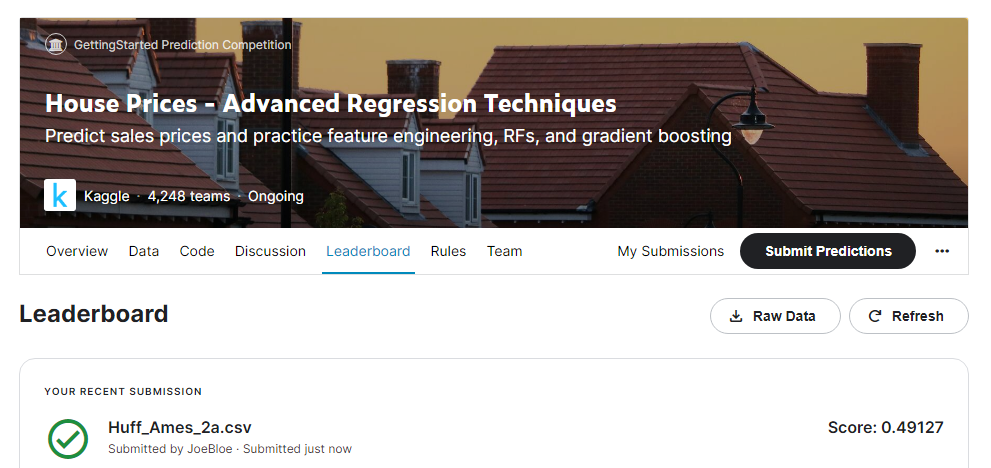

---------------------------------------------

**Week 3 score using expanded, but ElasticNet-regularized model = 0.38132 (slightly better).**

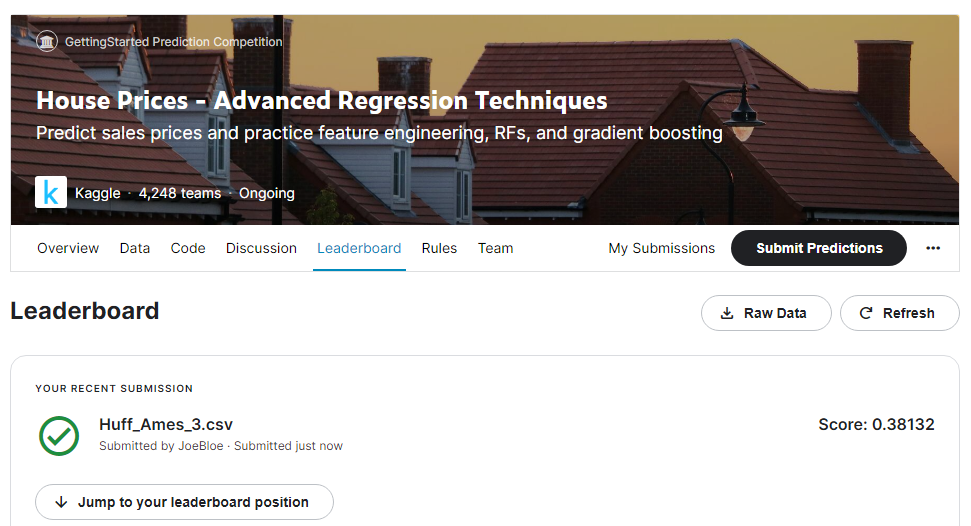

-------------------------------------------------------

**However, neither of the Week 3 scores (with expanded models) compared to last week's score (with a simpler model):**

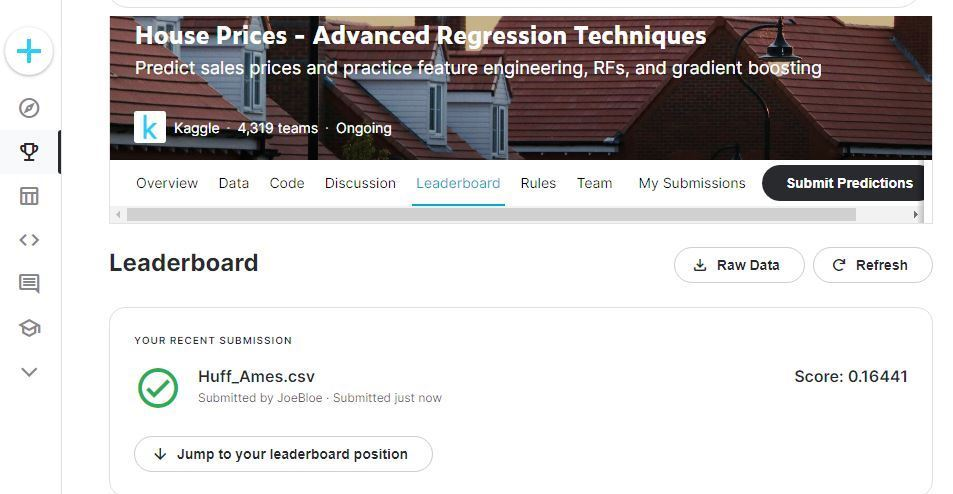

# ASSIGNMENT SUMMARY

In this exercise, a large dataset, consisting of approximately 80 variables and 1460 runs, was analyzed and then used to create a linear regression model for predicting Sales Prices of houses in the Ames, Iowa region.

Various evaluations, manipulations and transformations were performed on the variables to improve their potential usefulness in a regression model. After examining plots of the original, housing 'SalePrice' response variable, this variable was log-transformed to produce a response variable with better Normality characteristics. The other variables in the dataset were considered as potential predictor variables. Initially, these variables were separated according to their variable type (i.e., continuous, intervallic, ordinal, non-ordinal-categorical and dichotomous/binary), and each group was evaluated to find the most promising predictors in each group (based largely upon the level of correlation with the response variable). Several new variables were obtained by combining original variables, and one of these new variables, 'TotArea', as well as its quadratic version ('TotArea2'), were eventually used in the final regression model. Common transformations, such as Min-Max scaling, were used to normalize predictor magnitudes.  A k-means, clustering approach was used to group similar categories of the 'Neighborhood' categorical variable to reduce the number of different categories and simplify this predictor.

The predictors that were eventually included in the model are not surprising.   
'Neighborhood' addresses the "Location, Location, Location" aspect commonly associated with real estate valuation,  'TotArea' corresponds with the size of the house, 'YearBuilt' corresponds with the "newness" of the house, and 'OverallCond' corresponds with the general condition of the house.  After The dichotomous, (Y/N) variable 'CentralAir' was converted to (1/0) binary, this variable was also included in the model.  Although this variable was largely included so that the model would possess a dichotomous variable, houses that lack Central Air Conditioning tended to be associated with lower=priced houses.

Creating a linear regression model from a large dataset was challenging, and many interesting techniques were explored within this assignment.  It is likely further improvements could be made to the model.  However, we will continue to look at this dataset in coming weeks and in future assignments, so further opportunities will be available to improve the current model.